# Environment Setting

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random

In [3]:
### Set Seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

set_seed(44)

In [4]:
class Field_4:
    def __init__(self, size, start_position, target_position, parking_lot_coor):
        self.size = size
        self.parking = False  # true or false, park or not park, start with not park
        self.target_position = target_position  # there is a target position which has high reward
        self.position = start_position  # determine start position
        self.parking_lot_coor = parking_lot_coor  # there are other empty lots, keep them in a list
        self.start_position = start_position

    def reset(self):
        """Reset the environment to the initial state."""
        self.position = self.start_position  # Reset agent's position to the start
        # Add other resetting logic if needed, e.g., rewards, obstacles, etc.
        return self.get_state()  # Return the initial state

    def get_number_of_states(self):
        return self.size * self.size * 2  # multiply by 2 to add status of parked or not

    def get_state(self):
        # print(self.position)
        # state goes like (0,0,F), (0,0,T), (0,1,F), (0,1,T), (0,2,F)...
        state = self.position[0] * self.size * 2
        state = state + self.position[1] * 2

        # if parking is done, you'll be in the next state F-->T (*,*,T)
        if self.parking:
            state = state + 1
        return state

    def make_action(self, action):

        def calc_reward():
            distance = math.dist(self.position, self.target_position)

            # we want to maximize reward, minimize distance
            reward = -1 * (distance)

            return reward

        (x, y) = self.position
        if action == 0:  # down
            if y == self.size - 1: # penalize for out of canvas
                return -20, False
            elif x == 5 or x == 11: # go in the true direction
                self.position = (x, y + 1)
                return -1, False
            elif (x, y) == (0, 7) or (x, y) == (0, 12): # go in the true direction
                self.position = (x, y + 1)
                return -1, False
            else:
                return -20, False # penalize for out of road

        elif action == 1:  # up
            if y == 0: # penalize for out of canvas
                return -20, False
            elif x == 6 or x == 12: # go in the true direction
                self.position = (x, y - 1)
                return -1, False
            elif (x, y) == (self.size - 1, 8) or (x, y) == (self.size - 1, 13): # go in the true direction
                self.position = (x, y - 1)
                return -1, False
            else:
                return -20, False # penalize for out of road

        elif action == 2:  # left
            if x == 0: # penalize for out of canvas
                return -20, False
            elif y == 7 or y == 12: # go in the true direction
                self.position = (x - 1, y)
                return -1, False
            elif (x, y) == (6, 0) or (x, y) == (12, 0): # go in the true direction
                self.position = (x - 1, y)
                return -1, False
            else:
                return -20, False # penalize for out of road

        elif action == 3:  # right
            if x == self.size - 1: # penalize for out of canvas
                return -20, False
            elif y == 8 or y == 13: # go in the true direction
                self.position = (x + 1, y)
                return -1, False
            elif (x, y) == (5, self.size - 1) or (x, y) == (11, self.size - 1): # go in the true direction
                self.position = (x + 1, y)
                return -1, False
            else:
                return -20, False # penalize for out of road

        elif action == 4:  # park
            if [x, y] not in self.parking_lot_coor: # if it's not a parking lot
                return -20, False
            elif self.target_position == (x, y):
                reward = calc_reward()
                self.parking = True
                return reward + 50, True # yey it's target!!! #calculate -distance + 20 as a reward
            else:
                reward = calc_reward()
                self.parking = True
                return reward - 50, True # no target position but it's a lot #finish the loop #calculate -distance as a reward



In [5]:
from PIL import Image, ImageDraw, ImageFont
import os

def draw_area(start_position, target_position, parking_lot_coor, current_location, episode, step):
    # Create the image at the desired canvas size (e.g., 200x200)
    image = Image.new("RGB", (200, 200), "white")
    draw = ImageDraw.Draw(image)
    
    # Load a default font for coordinates
    font = ImageFont.truetype("DejaVuSans.ttf", size=6)  # 크기 설정 가능

    # Create a gray gradient background (fancy gray to lighter gray effect)
    for y in range(200):
        for x in range(200):
            color = (int(200 + (x * 0.2)), int(200 + (y * 0.2)), int(200 + (y * 0.2)))
            draw.point((x, y), fill=color)
    
    # Draw grid lines and add coordinates
    for i in range(0, 200, 10):
        # Horizontal grid lines
        draw.line([(0, i), (200, i)], fill="lightgray", width=1)
        # Vertical grid lines
        draw.line([(i, 0), (i, 200)], fill="lightgray", width=1)
        # Add row and column coordinates

    
    # Draw target place as a building with details (roof, windows, door)
    target_position = list(target_position)
    draw.rectangle((target_position[0] * 10, target_position[1] * 10,
                    (target_position[0] * 10) + 15, (target_position[1] * 10) + 25),
                   fill="lightgray", outline="black", width=2)  # Building base
    draw.polygon([(target_position[0] * 10, target_position[1] * 10),
                  (target_position[0] * 10 + 15, target_position[1] * 10),
                  (target_position[0] * 10 + 7, target_position[1] * 10 - 8)],
                 fill="darkgray", outline="black")  # Roof
    draw.rectangle((target_position[0] * 10 + 3, target_position[1] * 10 + 5,
                    target_position[0] * 10 + 6, target_position[1] * 10 + 8),
                   fill="lightblue", outline="black")  # Window 1
    draw.rectangle((target_position[0] * 10 + 9, target_position[1] * 10 + 5,
                    target_position[0] * 10 + 12, target_position[1] * 10 + 8),
                   fill="lightblue", outline="black")  # Window 2
    draw.rectangle((target_position[0] * 10 + 7, target_position[1] * 10 + 15,
                    target_position[0] * 10 + 11, target_position[1] * 10 + 23),
                   fill="brown", outline="black")  # Door

    # Draw roads
    road_color = (50, 50, 50)
    draw.line([(50, 0), (50, 70), (0, 70)], width=3, fill=road_color, joint="curve")
    draw.line([(0, 90), (50, 90), (50, 120), (0, 120)], width=3, fill=road_color, joint="curve")
    draw.line([(0, 140), (50, 140), (50, 200)], width=3, fill=road_color, joint="curve")
    draw.line([(70, 0), (70, 70), (110, 70), (110, 0)], width=3, fill=road_color, joint="curve")
    draw.line([(70, 90), (70, 120), (110, 120), (110, 90), (70, 90)], width=3, fill=road_color, joint="curve")
    draw.line([(70, 200), (70, 140), (110, 140), (110, 200)], width=3, fill=road_color, joint="curve")
    draw.line([(130, 0), (130, 70), (200, 70)], width=3, fill=road_color, joint="curve")
    draw.line([(200, 90), (130, 90), (130, 120), (200, 120)], width=3, fill=road_color, joint="curve")
    draw.line([(200, 140), (130, 140), (130, 200)], width=3, fill=road_color, joint="curve")

    # Show available parking lots
    for park in parking_lot_coor:
        draw.text((park[0] * 10 + 2, park[1] * 10 + 2), "X", fill=(34, 139, 34), font=font)

    # Show starting position
    start_position = list(start_position)
    draw.polygon([(start_position[0] * 10, start_position[1] * 10),
                  (start_position[0] * 10 + 10, start_position[1] * 10),
                  (start_position[0] * 10, start_position[1] * 10 + 10)],
                 fill="red", outline="black")
    draw.line([(start_position[0] * 10 + 5, start_position[1] * 10), 
               (start_position[0] * 10 + 5, start_position[1] * 10 + 15)], 
              fill="black", width=2)

    # Show moving agent
    current_location = list(current_location)
    draw.rectangle((current_location[0] * 10, current_location[1] * 10,
                    (current_location[0] * 10) + 20, (current_location[1] * 10) + 10),
                   fill="blue", outline="black", width=2)
    draw.ellipse((current_location[0] * 10 + 2, current_location[1] * 10 + 8,
                  current_location[0] * 10 + 8, current_location[1] * 10 + 14),
                 fill="black", outline="black")
    draw.ellipse((current_location[0] * 10 + 12, current_location[1] * 10 + 8,
                  current_location[0] * 10 + 18, current_location[1] * 10 + 14),
                 fill="black", outline="black")
    draw.rectangle((current_location[0] * 10 + 4, current_location[1] * 10 + 2,
                    current_location[0] * 10 + 16, current_location[1] * 10 + 6),
                   fill="lightblue", outline="black")
    draw.ellipse((current_location[0] * 10 + 5, current_location[1] * 10 + 1,
                  current_location[0] * 10 + 7, current_location[1] * 10 + 3),
                 fill="yellow", outline="black")
    draw.ellipse((current_location[0] * 10 + 13, current_location[1] * 10 + 1,
                  current_location[0] * 10 + 15, current_location[1] * 10 + 3),
                 fill="yellow", outline="black")

    # Draw dashed arrow between 5th and 6th columns (X = 50 to X = 60)
    dash_length = 5
    space_length = 5
    start_x = 5 * 10 + 5  # 위치를 55로 조정 (5번과 6번 컬럼 사이)
    arrow_head_size = 6  # 화살표 크기

    # Draw dashed line from top to bottom
    for y in range(0, 200, dash_length + space_length):
        if y + dash_length <= 200:  # Ensure the line does not exceed image boundary
            draw.line([(start_x, y), (start_x, y + dash_length)], fill="white", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points = [(start_x - arrow_head_size, 200 - arrow_head_size),
                        (start_x + arrow_head_size, 200 - arrow_head_size),
                        (start_x, 200)]
    draw.polygon(arrowhead_points, fill="white", outline="black")

    # Draw dashed arrow between 11th and 12th columns (X = 110 to X = 120)
    start_x_2 = 11 * 10 + 5  # 위치를 115로 조정 (11번과 12번 컬럼 사이)
    
    # Draw dashed line from top to bottom
    for y in range(0, 200, dash_length + space_length):
        if y + dash_length <= 200:  # Ensure the line does not exceed image boundary
            draw.line([(start_x_2, y), (start_x_2, y + dash_length)], fill="white", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_2 = [(start_x_2 - arrow_head_size, 200 - arrow_head_size),
                          (start_x_2 + arrow_head_size, 200 - arrow_head_size),
                          (start_x_2, 200)]
    draw.polygon(arrowhead_points_2, fill="white", outline="black")

    # Draw dashed arrow between 6th and 7th columns (X = 60 to X = 70) - Bottom to Top
    start_x_3 = 6 * 10 + 5  # 위치를 65로 조정 (6번과 7번 컬럼 사이)
    
    # Draw dashed line from bottom to top
    for y in range(200, 0, -(dash_length + space_length)):
        if y - dash_length >= 0:  # Ensure the line does not exceed image boundary
            draw.line([(start_x_3, y), (start_x_3, y - dash_length)], fill="white", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_3 = [(start_x_3 - arrow_head_size, 0 + arrow_head_size),
                          (start_x_3 + arrow_head_size, 0 + arrow_head_size),
                          (start_x_3, 0)]
    draw.polygon(arrowhead_points_3, fill="white", outline="black")

    # Draw dashed arrow between 12th and 13th columns (X = 120 to X = 130) - Bottom to Top
    start_x_4 = 12 * 10 + 5  # 위치를 125로 조정 (12번과 13번 컬럼 사이)
    
    # Draw dashed line from bottom to top
    for y in range(200, 0, -(dash_length + space_length)):
        if y - dash_length >= 0:  # Ensure the line does not exceed image boundary
            draw.line([(start_x_4, y), (start_x_4, y - dash_length)], fill="white", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_4 = [(start_x_4 - arrow_head_size, 0 + arrow_head_size),
                          (start_x_4 + arrow_head_size, 0 + arrow_head_size),
                          (start_x_4, 0)]
    draw.polygon(arrowhead_points_4, fill="white", outline="black")

    # Draw dashed arrow between 8th and 9th rows (Y = 80 to Y = 90) - Left to Right
    dash_length = 5
    space_length = 5
    start_y_1 = 8 * 10 + 5  # 위치를 85로 조정 (8번과 9번 row 사이)
    arrow_head_size = 6  # 화살표 크기

    # Draw dashed line from left to right
    for x in range(0, 200, dash_length + space_length):
        if x + dash_length <= 200:  # Ensure the line does not exceed image boundary
            draw.line([(x, start_y_1), (x + dash_length, start_y_1)], fill="yellow", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_1 = [(200 - arrow_head_size, start_y_1 - arrow_head_size),
                        (200, start_y_1),
                        (200 - arrow_head_size, start_y_1 + arrow_head_size)]
    draw.polygon(arrowhead_points_1, fill="yellow", outline="black")

    # Draw dashed arrow between 13th and 14th rows (Y = 130 to Y = 140) - Left to Right
    start_y_2 = 13 * 10 + 5  # 위치를 135로 조정 (13번과 14번 row 사이)

    # Draw dashed line from left to right
    for x in range(0, 200, dash_length + space_length):
        if x + dash_length <= 200:  # Ensure the line does not exceed image boundary
            draw.line([(x, start_y_2), (x + dash_length, start_y_2)], fill="yellow", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_2 = [(200 - arrow_head_size, start_y_2 - arrow_head_size),
                        (200, start_y_2),
                        (200 - arrow_head_size, start_y_2 + arrow_head_size)]
    draw.polygon(arrowhead_points_2, fill="yellow", outline="black")



        # Draw dashed arrow between 7th and 8th columns (X = 70 to X = 80) - Right to Left
    dash_length = 5
    space_length = 5
    start_y_1 = 7 * 10 + 5  # 위치를 75로 조정 (7번과 8번 컬럼 사이)
    arrow_head_size = 6  # 화살표 크기

    # Draw dashed line from right to left
    for x in range(200, 0, -(dash_length + space_length)):
        if x - dash_length >= 0:  # Ensure the line does not exceed image boundary
            draw.line([(x, start_y_1), (x - dash_length, start_y_1)], fill="yellow", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_1 = [(x - dash_length + arrow_head_size, start_y_1 - arrow_head_size),
                        (x - dash_length, start_y_1),
                        (x - dash_length + arrow_head_size, start_y_1 + arrow_head_size)]
    draw.polygon(arrowhead_points_1, fill="yellow", outline="black")

    # Draw dashed arrow between 12th and 13th columns (X = 120 to X = 130) - Right to Left
    start_y_2 = 12 * 10 + 5  # 위치를 125로 조정 (12번과 13번 컬럼 사이)

    # Draw dashed line from right to left
    for x in range(200, 0, -(dash_length + space_length)):
        if x - dash_length >= 0:  # Ensure the line does not exceed image boundary
            draw.line([(x, start_y_2), (x - dash_length, start_y_2)], fill="yellow", width=2)

    # Draw arrowhead at the end of the line
    arrowhead_points_2 = [(x - dash_length + arrow_head_size, start_y_2 - arrow_head_size),
                        (x - dash_length, start_y_2),
                        (x - dash_length + arrow_head_size, start_y_2 + arrow_head_size)]
    draw.polygon(arrowhead_points_2, fill="yellow", outline="black")

    return image

# Example usage
start_position = (5, 5)
target_position = (10, 10)
parking_lot_coor = []
current_location = (6, 6)
episode = 1
step = 1
img = draw_area(start_position, target_position, parking_lot_coor, current_location, episode, step)
img.show()


In [6]:
def visualize_training_results(steps, rewards):
    """
    Visualize training rewards and steps over episodes with matching plot sizes and ticks.

    Args:
    steps (list): List of steps taken in each episode.
    rewards (list): List of rewards received in each episode.
    """
    # Create a shared figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.2})

    # Plot rewards per episode
    axes[0].plot(rewards, label="Rewards", linewidth=1.5, color='blue')
    axes[0].set_ylabel("Rewards")
    axes[0].set_title("Rewards per Episode")
    axes[0].legend()
    axes[0].grid()
    axes[0].tick_params(axis='both', which='both', direction='in', length=6)

    # Plot steps per episode
    axes[1].plot(steps, label="Steps", linewidth=1.5, color='orange')
    axes[1].set_xlabel("Episodes")
    axes[1].set_ylabel("Number of Steps")
    axes[1].set_title("Steps per Episode")
    axes[1].legend()
    axes[1].grid()
    axes[1].tick_params(axis='both', which='both', direction='in', length=6)

    # Ensure uniform ticks across both plots
    for ax in axes:
        ax.set_xlim(0, len(steps))  # Match x-axis limits
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.show()

# 동영상으로 변환

In [6]:
import cv2
import os
from natsort import natsorted  # 자연어 순서 정렬 라이브러리

def create_video_from_images(image_folder, output_video_path, fps = 10):
    # 폴더 내 모든 이미지 파일 이름을 가져오기
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    
    # 자연어 순서대로 정렬
    image_files = natsorted(image_files)

    # 첫 번째 이미지로 비디오 작성자 설정
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, layers = first_image.shape
    
    # VideoWriter 객체 생성 (mp4v 코덱 사용)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # mp4v 코덱 사용
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # 이미지 파일을 순차적으로 비디오에 추가
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)

        # 비디오에 이미지 추가
        video_writer.write(img)

    # 비디오 파일 저장 후 리소스 해제
    video_writer.release()

# 사용 예시
image_folder = "frame"  # 이미지가 저장된 폴
output_video_path = "output_video.mp4"  # 생성될 동영상 경로
create_video_from_images(image_folder, output_video_path)


ModuleNotFoundError: No module named 'cv2'

# Q-learning

In [8]:
import os
import numpy as np
import random
from PIL import Image

def reinforcement_q(alpha, gamma):
    # give constants
    size = 20 # size of the canvas/coordination system
    start_position = (19, 12) # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]] 

    # initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)

    # create number of states according to size
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # create empty q table
    q_table = np.zeros((number_of_states, number_of_actions))

    # determine hyperparameters
    alpha = alpha  # parameter to tune
    gamma = gamma  # parameter to tune
    # epsilon = 1  # start epsilon from 1
    # max_epsilon = 1
    # min_epsilon = 0.01
    # decay = 0.01  # use decay to balance exploration and exploitation
    epsilon = 1  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01
    epsilon_decay = 0.01
    
    # give number of episodes
    train_episodes = 500

    # keep the metrics to evaluate learning process
    steps = []  # keep number of steps
    target_or_not = []  # keep info of if the agent finds the target or parks at another location
    training_rewards = []  # keep rewards
    epsilon_list = []

    # Create the frame folder if it doesn't exist
    if not os.path.exists("frame_qlearning"):
        os.makedirs("frame_qlearning")

    for episode in range(train_episodes):
        # initialize env in the learning loop
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False  # to finish the episode

        step = 0
        total_training_rewards = 0
        
        while not done:  # if done is true, finish the episode
            state = field.get_state()  # start with learning state of the agent

            if random.uniform(0, 1) > epsilon:  # explore or exploit
                action = np.argmax(q_table[state])  # exploit
            else:
                action = random.randint(0, 4)  # explore

            reward, done = field.make_action(action)  # position can be changed

            total_training_rewards += reward  # sum rewards

            new_state = field.get_state()  # enter new state according to new position
            new_state_max = np.max(q_table[new_state])  # learn which q value is max for the next state to calculate q value

            # update q table
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                        reward + gamma * new_state_max - q_table[state, action])

            step += 1  # increase step value

            # Check if the agent is at the target position
            target_tf = False
            if field.position == field.target_position:
                target_tf = True

            # Save the image on every step of the last episode
            # if episode == train_episodes - 1:
            #     print(f"---------STEP-{step}---------")
            #     # Draw the current environment state and save the image
            #     image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

            #     # Save the image as PNG in the "frame" folder
            #     image.save(f"frame_qlearning/episode_{episode}_step_{step}.png")

        # Decay epsilon after each episode to gradually shift from exploration to exploitation
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)

        # Append the values of the current episode to their respective lists
        steps.append(step)
        target_or_not.append(target_tf)
        training_rewards.append(total_training_rewards)
        
        epsilon_list.append(epsilon)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilon_list


# # Example usage:
# avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilon_list = reinforcement_q_visual(alpha=0.1, gamma=0.6)
# visualize_training_results(steps, training_rewards)


In [10]:
# define the range of alpha and gamma values to explore
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

results_list = []  # dictionary to store the results

for alpha in alpha_values:
    for gamma in gamma_values:

        avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_q(alpha, gamma)

        count = 0
        for el in target_or_not:
            if el:
                count += 1

        results = {"alpha": alpha, "gamma": gamma, "avg_steps": avg_steps, "avg_rewards": avg_rewards,
                   "hitting_target": int(count / len(target_or_not) * 100)}
        results_list.append(results)

# print the results
for el in results_list:
    alpha = el["alpha"]
    gamma = el["gamma"]
    avg_step = el["avg_steps"]
    avg_rewards = el["avg_rewards"]
    hitting_target = el["hitting_target"]
    print(
        f"Alpha: {alpha}, Gamma: {gamma}, Avg Steps: {avg_step}, Avg Rewards: {avg_rewards}, Hitting Target: {hitting_target}%")

Alpha: 0.1, Gamma: 0.1, Avg Steps: 1346.118, Avg Rewards: -2737.5245993957315, Hitting Target: 58%
Alpha: 0.1, Gamma: 0.3, Avg Steps: 110.808, Avg Rewards: -756.1112997732732, Hitting Target: 86%
Alpha: 0.1, Gamma: 0.5, Avg Steps: 98.486, Avg Rewards: -656.2869905865068, Hitting Target: 85%
Alpha: 0.1, Gamma: 0.7, Avg Steps: 93.552, Avg Rewards: -660.292769893677, Hitting Target: 85%
Alpha: 0.1, Gamma: 0.9, Avg Steps: 92.068, Avg Rewards: -689.5917408104712, Hitting Target: 88%
Alpha: 0.3, Gamma: 0.1, Avg Steps: 1271.722, Avg Rewards: -2614.0421364991603, Hitting Target: 59%
Alpha: 0.3, Gamma: 0.3, Avg Steps: 69.094, Avg Rewards: -490.2910076217793, Hitting Target: 91%
Alpha: 0.3, Gamma: 0.5, Avg Steps: 65.518, Avg Rewards: -459.02783663934235, Hitting Target: 90%
Alpha: 0.3, Gamma: 0.7, Avg Steps: 68.096, Avg Rewards: -513.5146407214157, Hitting Target: 92%
Alpha: 0.3, Gamma: 0.9, Avg Steps: 62.154, Avg Rewards: -423.37934010851944, Hitting Target: 90%
Alpha: 0.5, Gamma: 0.1, Avg Step

In [19]:
import matplotlib.pyplot as plt

def plot_results(results_list):
    # Prepare data for plotting
    labels = []  # To store (alpha, gamma) labels
    avg_steps = []
    avg_rewards = []

    for res in results_list:
        labels.append(f"({res['alpha']}, {res['gamma']})")
        avg_steps.append(res["avg_steps"])
        avg_rewards.append(res["avg_rewards"])

    # Plot avg_steps
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_steps, marker='o', label="Average Steps")
    plt.title("Average Steps vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Steps")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot avg_rewards
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_rewards, marker='o', label="Average Rewards", color='orange')
    plt.title("Average Rewards vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Rewards")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Find best parameters
    best_avg_steps = min(zip(avg_steps, labels))
    best_avg_rewards = max(zip(avg_rewards, labels))

    print(f"Best Average Steps: {best_avg_steps[0]} at parameters {best_avg_steps[1]}")
    print(f"Best Average Rewards: {best_avg_rewards[0]} at parameters {best_avg_rewards[1]}")
# Example usage:
# plot_results(results_list)

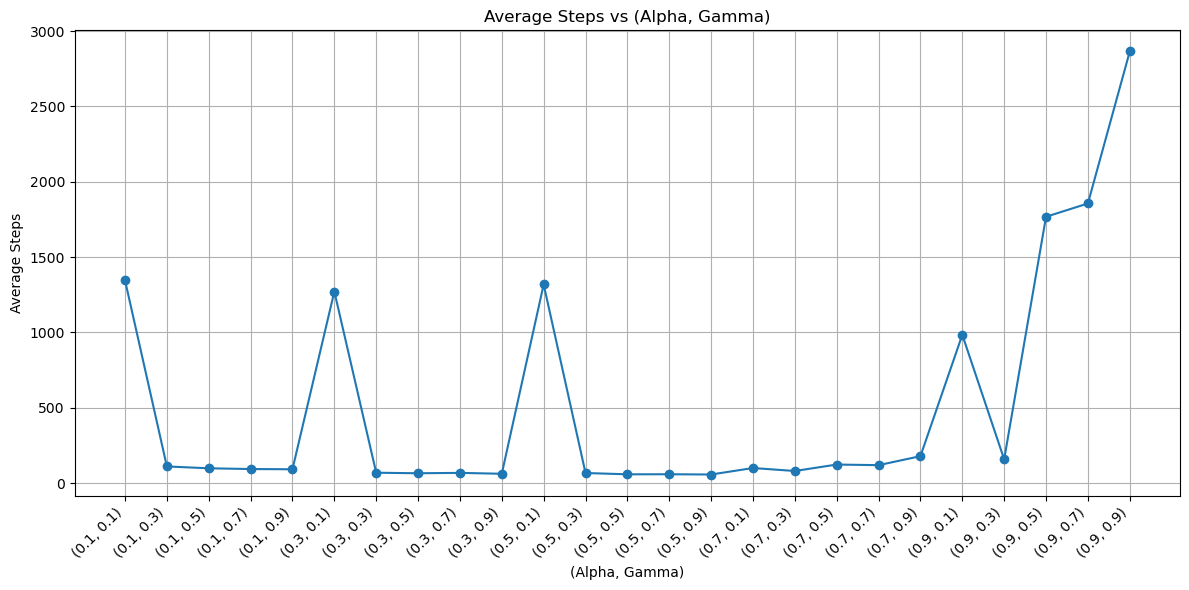

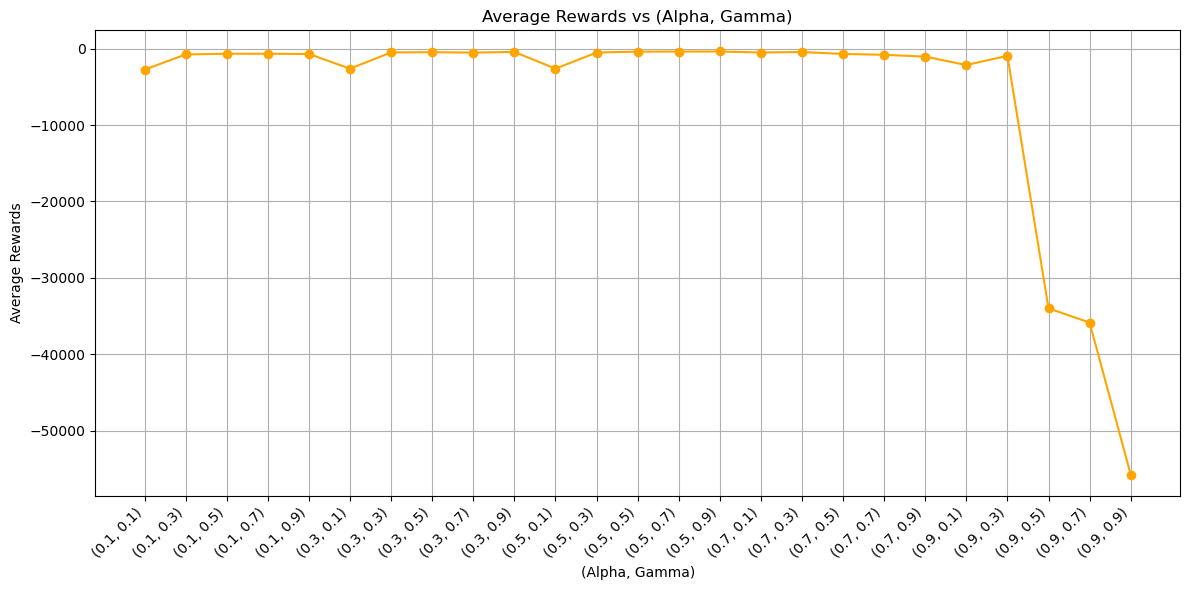

Best Average Steps: 57.268 at parameters (0.5, 0.9)
Best Average Rewards: -364.1218704052355 at parameters (0.5, 0.9)


In [20]:
plot_results(results_list)

#### Best Param: ($\alpha, \gamma$) = (0.5, 0.9)

---------STEP-1---------
---------STEP-2---------
---------STEP-3---------
---------STEP-4---------
---------STEP-5---------
---------STEP-6---------
---------STEP-7---------
---------STEP-8---------
---------STEP-9---------
---------STEP-10---------
---------STEP-11---------
---------STEP-12---------
---------STEP-13---------
---------STEP-14---------
---------STEP-15---------
---------STEP-16---------
---------STEP-17---------
---------STEP-18---------
---------STEP-19---------
---------STEP-20---------
---------STEP-21---------
---------STEP-22---------
---------STEP-23---------
---------STEP-24---------
---------STEP-25---------
---------STEP-26---------
---------STEP-27---------
---------STEP-28---------
---------STEP-29---------
---------STEP-30---------
---------STEP-31---------
---------STEP-32---------


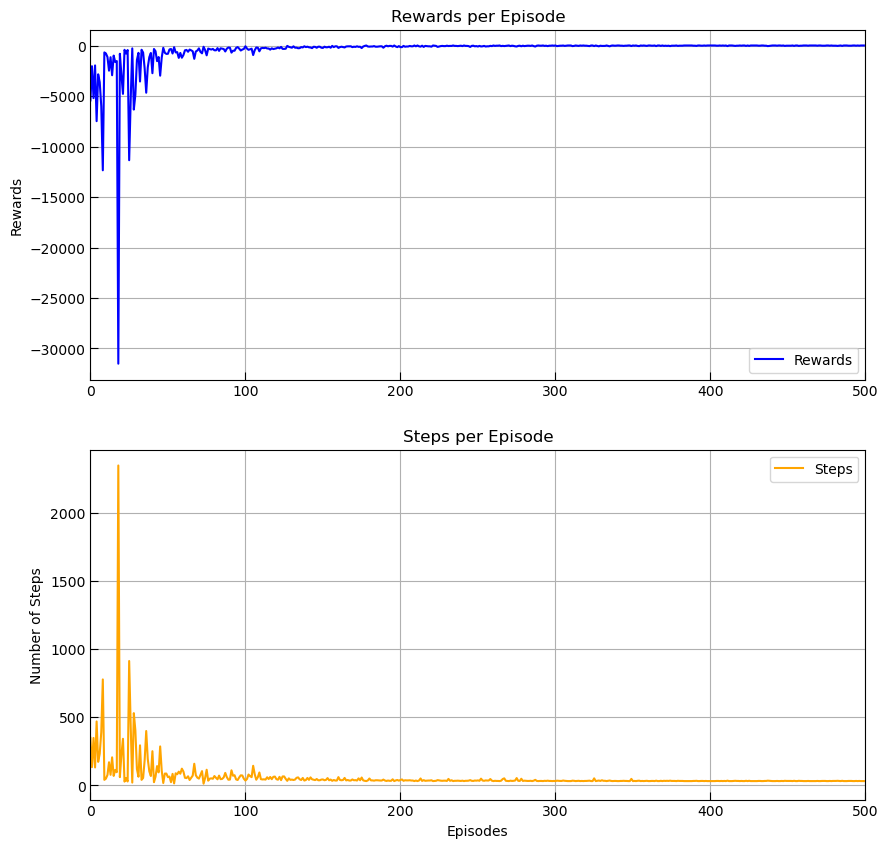

In [7]:
import os
import numpy as np
import random
from PIL import Image

set_seed(44)

def reinforcement_q(alpha, gamma):
    # give constants
    size = 20 # size of the canvas/coordination system
    start_position = (19, 12) # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]] 

    # initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # create number of states according to size
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # create empty q table
    q_table = np.zeros((number_of_states, number_of_actions))

    # determine hyperparameters
    alpha = alpha  # parameter to tune
    gamma = gamma  # parameter to tune
    # epsilon = 1  # start epsilon from 1
    # max_epsilon = 1
    # min_epsilon = 0.01
    # decay = 0.01  # use decay to balance exploration and exploitation
    epsilon = 1  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01
    epsilon_decay = 0.01
    
    # give number of episodes
    train_episodes = 500

    # keep the metrics to evaluate learning process
    steps = []  # keep number of steps
    target_or_not = []  # keep info of if the agent finds the target or parks at another location
    training_rewards = []  # keep rewards
    epsilon_list = []

    # Create the frame folder if it doesn't exist
    if not os.path.exists("frame_qlearning"):
        os.makedirs("frame_qlearning")

    for episode in range(train_episodes):
        # initialize env in the learning loop
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False  # to finish the episode

        step = 0
        total_training_rewards = 0
        
        while not done:  # if done is true, finish the episode
            state = field.get_state()  # start with learning state of the agent

            if random.uniform(0, 1) > epsilon:  # explore or exploit
                action = np.argmax(q_table[state])  # exploit
            else:
                action = random.randint(0, 4)  # explore

            reward, done = field.make_action(action)  # position can be changed

            total_training_rewards += reward  # sum rewards

            new_state = field.get_state()  # enter new state according to new position
            new_state_max = np.max(q_table[new_state])  # learn which q value is max for the next state to calculate q value

            # update q table
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                        reward + gamma * new_state_max - q_table[state, action])

            step += 1  # increase step value

            # Check if the agent is at the target position
            target_tf = False
            if field.position == field.target_position:
                target_tf = True

            # Save the image on every step of the last episode
            if episode == train_episodes - 1:
                print(f"---------STEP-{step}---------")
                # Draw the current environment state and save the image
                image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

                # Save the image as PNG in the "frame" folder
                image.save(f"frame_qlearning/episode_{episode}_step_{step}.png")

        # Decay epsilon after each episode to gradually shift from exploration to exploitation
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)

        # Append the values of the current episode to their respective lists
        steps.append(step)
        target_or_not.append(target_tf)
        training_rewards.append(total_training_rewards)
        
        epsilon_list.append(epsilon)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilon_list, q_table



avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilon_list, q_table = reinforcement_q(alpha=0.5, gamma=0.9)
visualize_training_results(steps, training_rewards)

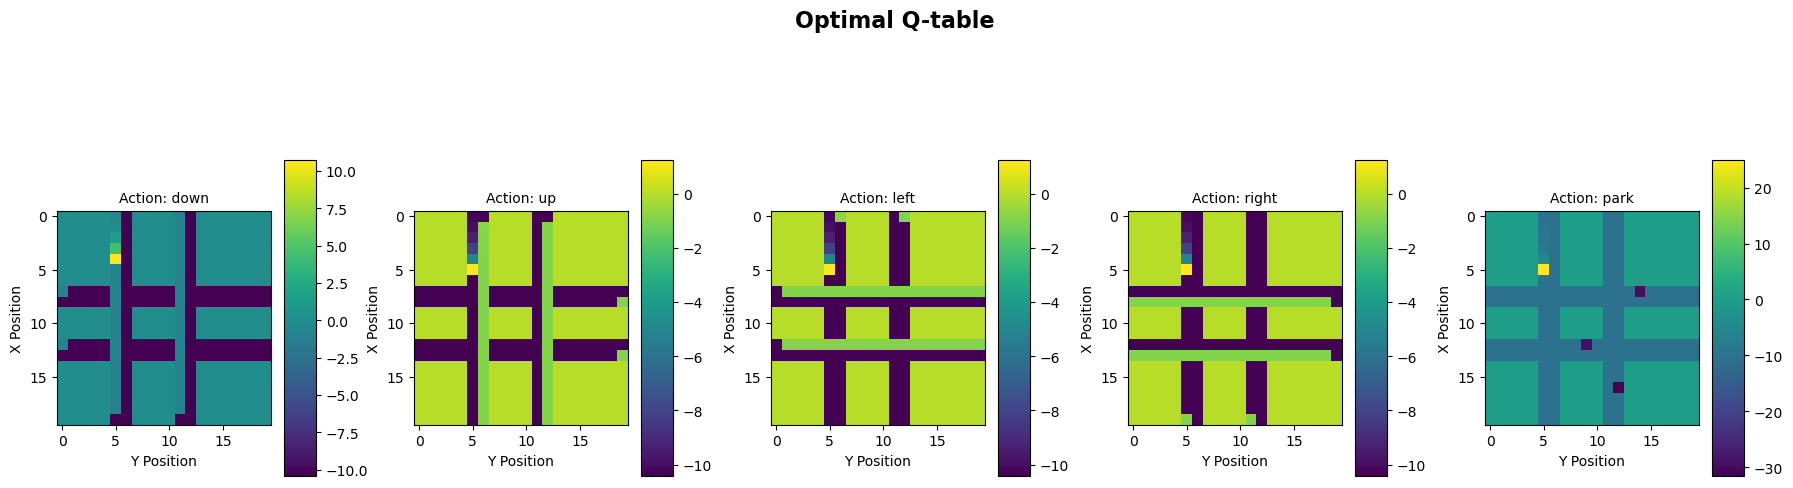

In [17]:
def visualize_q_table_parking_with_labels_reflected(q_table, grid_size=20):
    """
    Visualize Q-table for parking environment as heatmaps for each action, reflected across y = x axis.

    Parameters:
    - q_table: ndarray, shape (num_states, num_actions), Q-values for all states and actions.
    - grid_size: Integer, the size of the grid (e.g., 20 for a 20x20 grid).
    """
    # Convert Q-table to NumPy array if needed
    q_table = np.array(q_table)

    # Number of actions
    num_actions = q_table.shape[1]
    action_labels = ["down", "up", "left", "right", "park"]

    # Separate Q-values for parked (T) and not parked (F) states
    q_table_not_parked = q_table[::2, :]  # States where parking is False

    # Reflect the data across y = x by transposing
    def reflect_across_y_equals_x(data, action, grid_size):
        reshaped = data[:, action].reshape(grid_size, grid_size)
        return reshaped.T  # Transpose the grid to reflect across y = x

    plt.figure(figsize=(18, 10))
    plt.suptitle("Optimal Q-table", fontsize=16, weight='bold')  # Add the title

    for action in range(num_actions):
        # Plot Q-values for not parked states
        plt.subplot(2, num_actions, action + 1)
        reflected_not_parked = reflect_across_y_equals_x(q_table_not_parked, action, grid_size)
        im = plt.imshow(
            reflected_not_parked,
            cmap="viridis",
            interpolation="nearest"
        )
        plt.title(f"Action: {action_labels[action]}", fontsize=10)
        plt.xlabel("Y Position")
        plt.ylabel("X Position")

        # Adjust the colorbar size and position
        cbar = plt.colorbar(im, shrink=0.7, aspect=10)  # Reduce the colorbar size

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

# 시각화 실행
visualize_q_table_parking_with_labels_reflected(q_table, grid_size=20)


(0.0, 500.0)

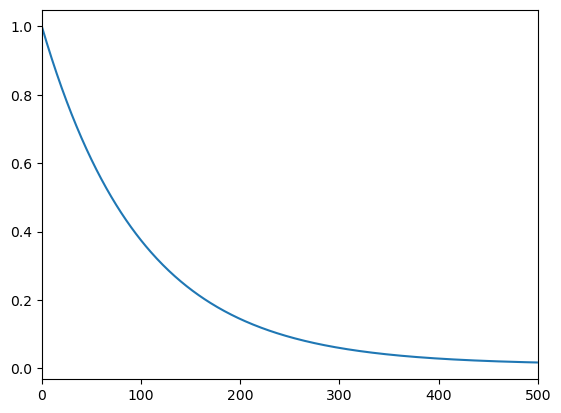

In [18]:
### epsilon decay plot ###
plt.plot(epsilon_list)   ######## Explore 를 많이 하면 안좋음
plt.xlim([0.,500])

# Double Q-learning

In [33]:
def reinforcement_double_q(alpha, gamma):
    # Constants
    size = 20  # size of the canvas/coordination system
    start_position = (19, 12)  # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]]  # all empty parking space location

    # Initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)

    # Create number of states and actions
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # Create two Q-tables for Double Q-learning
    q_table_a = np.zeros((number_of_states, number_of_actions))
    q_table_b = np.zeros((number_of_states, number_of_actions))
    
    # Create the frame folder if it doesn't exist
    # frame_folder = "frame_double_qlearning_base"
    # if not os.path.exists(frame_folder):
    #     os.makedirs(frame_folder)
    
    # Hyperparameters
    epsilon = 1.0  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01  # lower bound to stop exploration
    decay = 0.01  # epsilon decay rate

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    for episode in range(train_episodes):
        field = Field_4(size, start_position, target_position, parking_lot_coor)

        # Initialize environment
        done = False
        step = 0
        total_training_rewards = 0
        state = field.get_state()

        while not done:
            # Choose action using epsilon-greedy policy based on combined Q-tables
            if random.uniform(0, 1) > epsilon:  # Exploit
                action_a = np.argmax(q_table_a[state])
                action_b = np.argmax(q_table_b[state])
                action = action_a if q_table_a[state, action_a] + q_table_b[state, action_b] > q_table_a[state, action_b] + q_table_b[state, action_a] else action_b
            else:  # Explore
                action = random.randint(0, number_of_actions - 1)


            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Flip a coin to decide which Q-table to update
            if random.uniform(0, 1) < 0.5:
                # Update Q-table A
                best_action = np.argmax(q_table_a[new_state])
                q_table_a[state, action] = (1 - alpha) * q_table_a[state, action] + alpha * (
                    reward + gamma * q_table_b[new_state, best_action] - q_table_a[state, action]
                )
            else:
                # Update Q-table B
                best_action = np.argmax(q_table_b[new_state])
                q_table_b[state, action] = (1 - alpha) * q_table_b[state, action] + alpha * (
                    reward + gamma * q_table_a[new_state, best_action] - q_table_b[state, action]
                )

            # if episode == train_episodes-1:
            #     print(f"---------STEP-{step}---------")

            #     image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

            #     # Save the image as PNG in the "frame" folder
            #     image.save(f"frame_double_qlearning_base/episode_{episode}_step_{step}.png")
            
            state = new_state
            step += 1

        # Check if the agent reached the target
        target_tf = field.position == field.target_position
        
        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        
        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons

# avg_steps, avg_rewards, steps, training_rewards, epsilons, target_or_not = reinforcement_double_q(alpha=0.1, gamma=0.6)
# visualize_training_results(steps, training_rewards)

In [34]:
# define the range of alpha and gamma values to explore
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

results_list = []  # dictionary to store the results

for alpha in alpha_values:
    for gamma in gamma_values:
        avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_double_q(alpha, gamma)
        count = 0
        for el in target_or_not:
            if el:
                count += 1

        results = {"alpha": alpha, "gamma": gamma, "avg_steps": avg_steps, "avg_rewards": avg_rewards,
                   "hitting_target": int(count / len(target_or_not) * 100)}
        results_list.append(results)
        
# print the results
for el in results_list:
    alpha = el["alpha"]
    gamma = el["gamma"]
    avg_step = el["avg_steps"]
    avg_rewards = el["avg_rewards"]
    hitting_target = el["hitting_target"]
    print(
        f"Alpha: {alpha}, Gamma: {gamma}, Avg Steps: {avg_step}, Avg Rewards: {avg_rewards}, Hitting Target: {hitting_target}%")

Alpha: 0.1, Gamma: 0.1, Avg Steps: 1179.976, Avg Rewards: -2235.74452064048, Hitting Target: 82%
Alpha: 0.1, Gamma: 0.3, Avg Steps: 1066.46, Avg Rewards: -2150.9890364868784, Hitting Target: 62%
Alpha: 0.1, Gamma: 0.5, Avg Steps: 530.024, Avg Rewards: -1672.8667177835518, Hitting Target: 80%
Alpha: 0.1, Gamma: 0.7, Avg Steps: 2188.506, Avg Rewards: -4175.484338472088, Hitting Target: 14%
Alpha: 0.1, Gamma: 0.9, Avg Steps: 402.468, Avg Rewards: -1295.5905513935304, Hitting Target: 80%
Alpha: 0.3, Gamma: 0.1, Avg Steps: 400.93, Avg Rewards: -1813.9852439123038, Hitting Target: 75%
Alpha: 0.3, Gamma: 0.3, Avg Steps: 101.964, Avg Rewards: -651.4993036698396, Hitting Target: 90%
Alpha: 0.3, Gamma: 0.5, Avg Steps: 116.834, Avg Rewards: -663.4744039181159, Hitting Target: 90%
Alpha: 0.3, Gamma: 0.7, Avg Steps: 124.854, Avg Rewards: -720.5702932385401, Hitting Target: 82%
Alpha: 0.3, Gamma: 0.9, Avg Steps: 108.394, Avg Rewards: -865.7572287317289, Hitting Target: 93%
Alpha: 0.5, Gamma: 0.1, Av

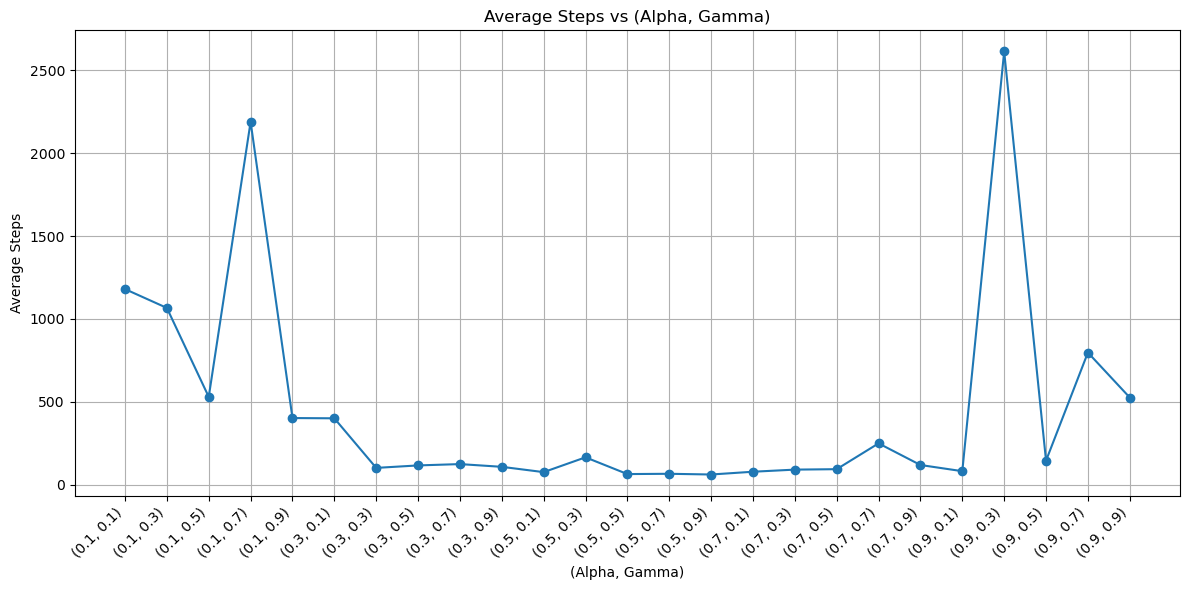

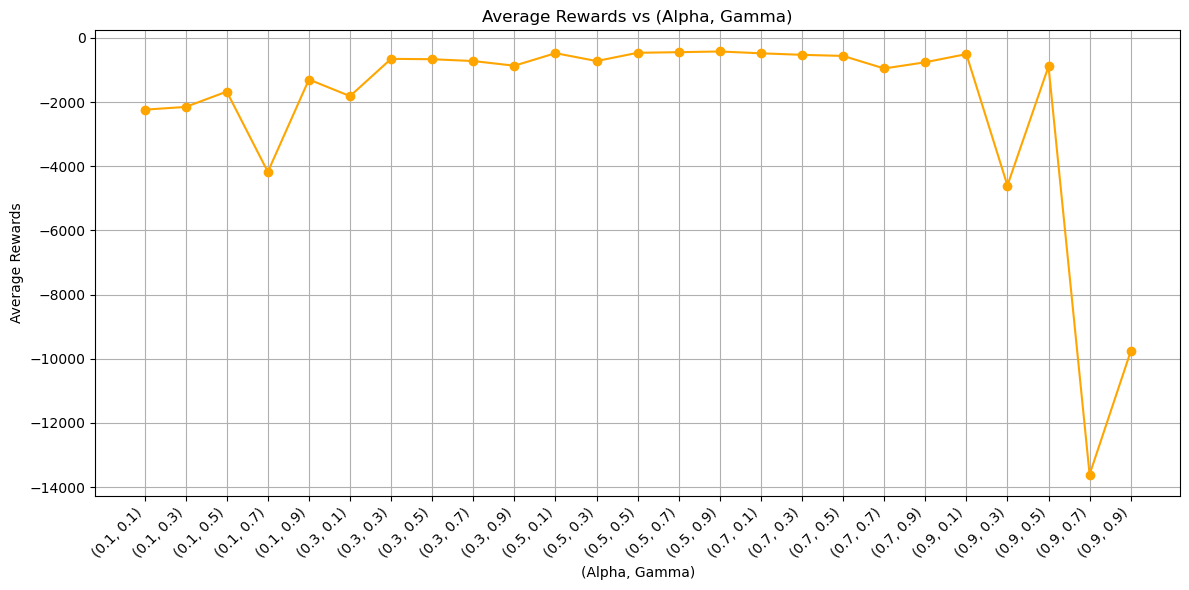

Best Average Steps: 62.084 at parameters (0.5, 0.9)
Best Average Rewards: -422.1656705345084 at parameters (0.5, 0.9)


In [35]:
def plot_results(results_list):
    # Prepare data for plotting
    labels = []  # To store (alpha, gamma) labels
    avg_steps = []
    avg_rewards = []

    for res in results_list:
        labels.append(f"({res['alpha']}, {res['gamma']})")
        avg_steps.append(res["avg_steps"])
        avg_rewards.append(res["avg_rewards"])

    # Plot avg_steps
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_steps, marker='o', label="Average Steps")
    plt.title("Average Steps vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Steps")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot avg_rewards
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_rewards, marker='o', label="Average Rewards", color='orange')
    plt.title("Average Rewards vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Rewards")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Find best parameters
    best_avg_steps = min(zip(avg_steps, labels))
    best_avg_rewards = max(zip(avg_rewards, labels))

    print(f"Best Average Steps: {best_avg_steps[0]} at parameters {best_avg_steps[1]}")
    print(f"Best Average Rewards: {best_avg_rewards[0]} at parameters {best_avg_rewards[1]}")

plot_results(results_list)

#### Best Params = ($\alpha, \gamma$) = (0.5, 0.9)

In [19]:
set_seed(44)

def reinforcement_double_q(alpha, gamma):
    # Constants
    size = 20  # size of the canvas/coordination system
    start_position = (19, 12)  # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]]  # all empty parking space location

    # Initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Create number of states and actions
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # Create two Q-tables for Double Q-learning
    q_table_a = np.zeros((number_of_states, number_of_actions))
    q_table_b = np.zeros((number_of_states, number_of_actions))
    
    # Create the frame folder if it doesn't exist
    frame_folder = "frame_double_qlearning"
    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)
    
    # Hyperparameters
    epsilon = 1.0  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01  # lower bound to stop exploration
    decay = 0.01  # epsilon decay rate

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    for episode in range(train_episodes):
        field = Field_4(size, start_position, target_position, parking_lot_coor)

        # Initialize environment
        done = False
        step = 0
        total_training_rewards = 0
        state = field.get_state()

        while not done:
            # Choose action using epsilon-greedy policy based on combined Q-tables
            if random.uniform(0, 1) > epsilon:  # Exploit
                action_a = np.argmax(q_table_a[state])
                action_b = np.argmax(q_table_b[state])
                action = action_a if q_table_a[state, action_a] + q_table_b[state, action_b] > q_table_a[state, action_b] + q_table_b[state, action_a] else action_b
            else:  # Explore
                action = random.randint(0, number_of_actions - 1)


            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Flip a coin to decide which Q-table to update
            if random.uniform(0, 1) < 0.5:
                # Update Q-table A
                best_action = np.argmax(q_table_a[new_state])
                q_table_a[state, action] = (1 - alpha) * q_table_a[state, action] + alpha * (
                    reward + gamma * q_table_b[new_state, best_action] - q_table_a[state, action]
                )
            else:
                # Update Q-table B
                best_action = np.argmax(q_table_b[new_state])
                q_table_b[state, action] = (1 - alpha) * q_table_b[state, action] + alpha * (
                    reward + gamma * q_table_a[new_state, best_action] - q_table_b[state, action]
                )

            ########results saving##########    
            if episode == train_episodes-1:
                print(f"---------STEP-{step+1}---------")

                image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

                # Save the image as PNG in the "frame" folder
                image.save(f"frame_double_qlearning/episode_{episode}_step_{step}.png")
            
            state = new_state
            step += 1

        # Check if the agent reached the target
        target_tf = field.position == field.target_position
        
        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        
        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons

---------STEP-1---------
---------STEP-2---------
---------STEP-3---------
---------STEP-4---------
---------STEP-5---------
---------STEP-6---------
---------STEP-7---------
---------STEP-8---------
---------STEP-9---------
---------STEP-10---------
---------STEP-11---------
---------STEP-12---------
---------STEP-13---------
---------STEP-14---------
---------STEP-15---------
---------STEP-16---------
---------STEP-17---------
---------STEP-18---------
---------STEP-19---------
---------STEP-20---------
---------STEP-21---------
---------STEP-22---------
---------STEP-23---------
---------STEP-24---------
---------STEP-25---------
---------STEP-26---------
---------STEP-27---------
---------STEP-28---------
---------STEP-29---------
---------STEP-30---------
---------STEP-31---------
---------STEP-32---------


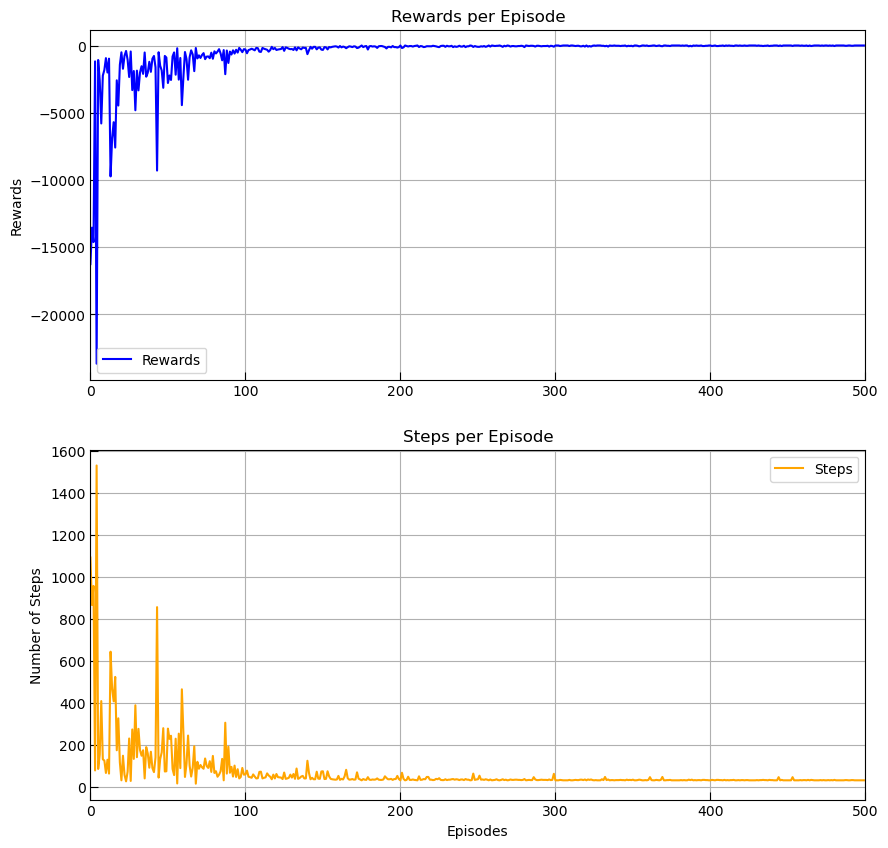

In [20]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_double_q(alpha = 0.5, gamma=0.9)
visualize_training_results(steps, training_rewards)

# SARSA

In [24]:
set_seed(44)

def reinforcement_sarsa(alpha, gamma):
    # Constants
    size = 20 # size of the canvas/coordination system
    start_position = (19, 12) # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]] 
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Initialize number of states and actions
    number_of_actions = 5  # left, right, up, down, park
    number_of_states = field.get_number_of_states()


 
    # Create empty Q-table with small random values
    # q_table = np.random.rand(number_of_states, number_of_actions) * 0.1
    q_table = np.random.rand(number_of_states, number_of_actions) 

    # Hyperparameters
    epsilon = 1  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01
    epsilon_decay = 0.01

    # alpha_initial = 0.4
    # alpha_min = 0.01
    # alpha_decay = 0.4
    # alpha = 0.1

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    # # Create the frame folder if it doesn't exist
    # frame_folder = "frame_sarsa_base"
    # if not os.path.exists(frame_folder):
    #     os.makedirs(frame_folder)

    for episode in range(train_episodes):
        # Reinitialize environment for each episode
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False
        step = 0
        total_training_rewards = 0

        # Initial state and action
        state = field.get_state()
        if random.uniform(0, 1) > epsilon:  # Exploit
            action = np.argmax(q_table[state])
        else:  # Explore
            action = random.randint(0, 4)

        while not done:
            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Select next action (SARSA-specific step)
            if random.uniform(0, 1) > epsilon:  # Exploit
                new_action = np.argmax(q_table[new_state])
            else:  # Explore
                new_action = random.randint(0, 4)

            # Update Q-value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * q_table[new_state, new_action] - q_table[state, action]
            )

            # Update state and action
            state = new_state
            action = new_action
            step += 1

            # # Save the current state as an image for the last episode
            # if episode == train_episodes - 1:
            #     image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)
            #     print(f"---------STEP-{step}---------")

            #     # Save the image as PNG in the "frame" folder
            #     image.save(f"{frame_folder}/episode_{episode}_step_{step}.png")

        # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)
        # alpha = max(alpha_min, alpha_initial * alpha_decay**episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons


In [25]:
# define the range of alpha and gamma values to explore
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

results_list = []  # dictionary to store the results

for alpha in alpha_values:
    for gamma in gamma_values:

        avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_sarsa(alpha, gamma)

        count = 0
        for el in target_or_not:
            if el:
                count += 1

        results = {"alpha": alpha, "gamma": gamma, "avg_steps": avg_steps, "avg_rewards": avg_rewards,
                   "hitting_target": int(count / len(target_or_not) * 100)}
        results_list.append(results)

# print the results
for el in results_list:
    alpha = el["alpha"]
    gamma = el["gamma"]
    avg_step = el["avg_steps"]
    avg_rewards = el["avg_rewards"]
    hitting_target = el["hitting_target"]
    print(
        f"Alpha: {alpha}, Gamma: {gamma}, Avg Steps: {avg_step}, Avg Rewards: {avg_rewards}, Hitting Target: {hitting_target}%")

Alpha: 0.1, Gamma: 0.1, Avg Steps: 81.694, Avg Rewards: -544.3470255707963, Hitting Target: 85%
Alpha: 0.1, Gamma: 0.3, Avg Steps: 102.19, Avg Rewards: -589.3180560726976, Hitting Target: 88%
Alpha: 0.1, Gamma: 0.5, Avg Steps: 182.602, Avg Rewards: -946.2266425188844, Hitting Target: 79%
Alpha: 0.1, Gamma: 0.7, Avg Steps: 233.058, Avg Rewards: -943.3975002917305, Hitting Target: 81%
Alpha: 0.1, Gamma: 0.9, Avg Steps: 204.53, Avg Rewards: -958.2619857089039, Hitting Target: 80%
Alpha: 0.3, Gamma: 0.1, Avg Steps: 147.328, Avg Rewards: -763.8620341035883, Hitting Target: 80%
Alpha: 0.3, Gamma: 0.3, Avg Steps: 129.468, Avg Rewards: -634.641389993289, Hitting Target: 86%
Alpha: 0.3, Gamma: 0.5, Avg Steps: 198.452, Avg Rewards: -801.9233097809947, Hitting Target: 84%
Alpha: 0.3, Gamma: 0.7, Avg Steps: 190.656, Avg Rewards: -885.6545592853414, Hitting Target: 83%
Alpha: 0.3, Gamma: 0.9, Avg Steps: 296.14, Avg Rewards: -1101.4549288995702, Hitting Target: 83%
Alpha: 0.5, Gamma: 0.1, Avg Steps:

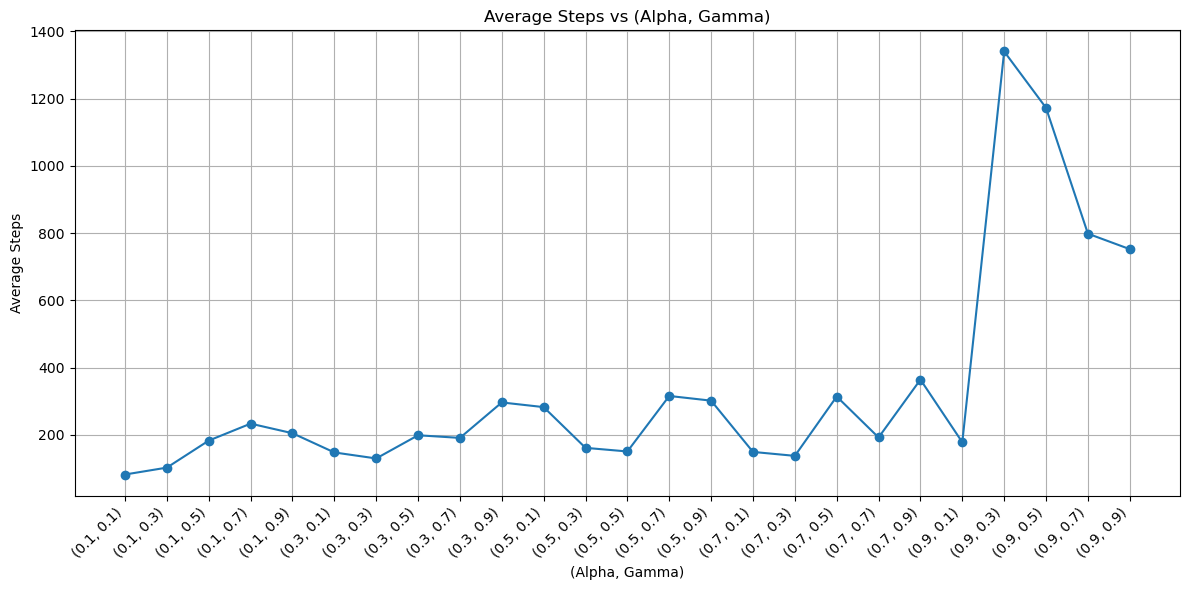

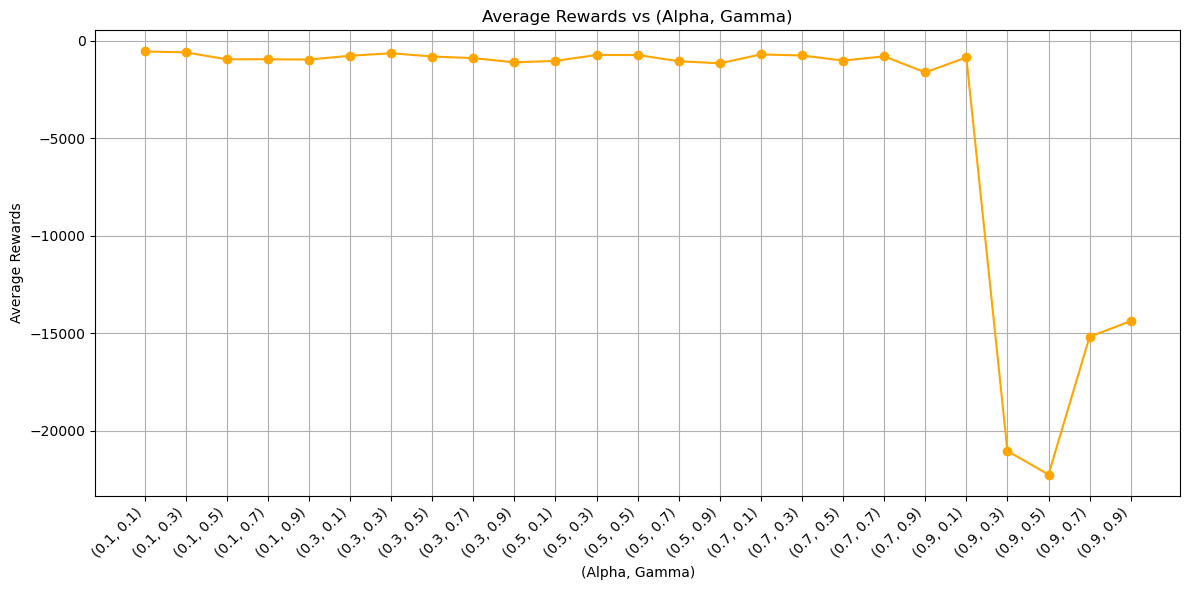

Best Average Steps: 81.694 at parameters (0.1, 0.1)
Best Average Rewards: -544.3470255707963 at parameters (0.1, 0.1)


In [26]:
import matplotlib.pyplot as plt

def plot_results(results_list):
    # Prepare data for plotting
    labels = []  # To store (alpha, gamma) labels
    avg_steps = []
    avg_rewards = []

    for res in results_list:
        labels.append(f"({res['alpha']}, {res['gamma']})")
        avg_steps.append(res["avg_steps"])
        avg_rewards.append(res["avg_rewards"])

    # Plot avg_steps
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_steps, marker='o', label="Average Steps")
    plt.title("Average Steps vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Steps")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot avg_rewards
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_rewards, marker='o', label="Average Rewards", color='orange')
    plt.title("Average Rewards vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Rewards")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Find best parameters
    best_avg_steps = min(zip(avg_steps, labels))
    best_avg_rewards = max(zip(avg_rewards, labels))

    print(f"Best Average Steps: {best_avg_steps[0]} at parameters {best_avg_steps[1]}")
    print(f"Best Average Rewards: {best_avg_rewards[0]} at parameters {best_avg_rewards[1]}")
# Example usage:
plot_results(results_list)

---------STEP-1---------
---------STEP-2---------
---------STEP-3---------
---------STEP-4---------
---------STEP-5---------
---------STEP-6---------
---------STEP-7---------
---------STEP-8---------
---------STEP-9---------
---------STEP-10---------
---------STEP-11---------
---------STEP-12---------
---------STEP-13---------
---------STEP-14---------
---------STEP-15---------
---------STEP-16---------
---------STEP-17---------
---------STEP-18---------
---------STEP-19---------
---------STEP-20---------
---------STEP-21---------
---------STEP-22---------
---------STEP-23---------
---------STEP-24---------
---------STEP-25---------
---------STEP-26---------
---------STEP-27---------
---------STEP-28---------
---------STEP-29---------
---------STEP-30---------
---------STEP-31---------
---------STEP-32---------


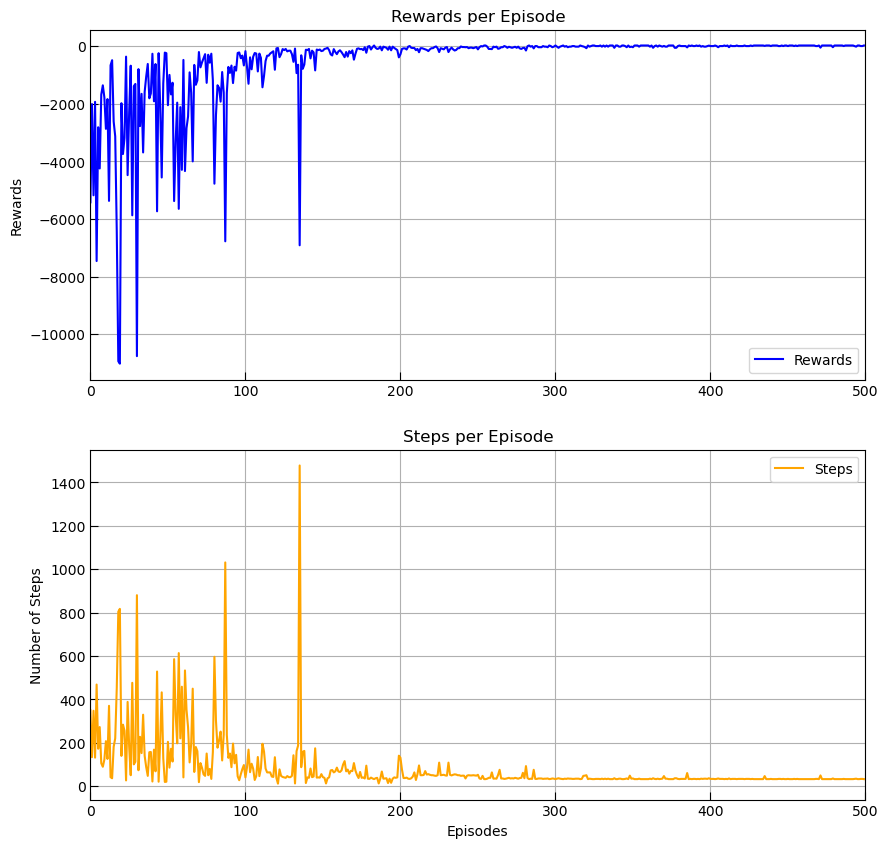

In [29]:
import matplotlib.pyplot as plt

set_seed(44)
def reinforcement_sarsa_base(alpha, gamma, epsilon_start=1.0, epsilon_decay=0.01, min_epsilon=0.01):
    # Constants
    size = 20 # size of the canvas/coordination system
    start_position = (19, 12) # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]] 
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Initialize number of states and actions
    number_of_actions = 5  # left, right, up, down, park
    number_of_states = field.get_number_of_states()


 
    # Create empty Q-table with small random values
    # q_table = np.random.rand(number_of_states, number_of_actions) * 0.1
    q_table = np.random.rand(number_of_states, number_of_actions) 

    # Hyperparameters
    epsilon = epsilon_start  # initial exploration probability
    max_epsilon = epsilon_start

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    # Create the frame folder if it doesn't exist
    frame_folder = "frame_sarsa_base"
    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)

    for episode in range(train_episodes):
        # Reinitialize environment for each episode
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False
        step = 0
        total_training_rewards = 0

        # Initial state and action
        state = field.get_state()
        if random.uniform(0, 1) > epsilon:  # Exploit
            action = np.argmax(q_table[state])
        else:  # Explore
            action = random.randint(0, 4)

        while not done:
            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Select next action (SARSA-specific step)
            if random.uniform(0, 1) > epsilon:  # Exploit
                new_action = np.argmax(q_table[new_state])
            else:  # Explore
                new_action = random.randint(0, 4)

            # Update Q-value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * q_table[new_state, new_action] - q_table[state, action]
            )

            # Update state and action
            state = new_state
            action = new_action
            step += 1

            # Save the current state as an image for the last episode
            if episode == train_episodes - 1:
                image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)
                print(f"---------STEP-{step}---------")

                # Save the image as PNG in the "frame" folder
                image.save(f"{frame_folder}/episode_{episode}_step_{step}.png")

        # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), np.mean(training_rewards), steps, training_rewards, epsilons, target_or_not

avg_steps, avg_rewards, steps, training_rewards, epsilons, target_or_not = reinforcement_sarsa_base(alpha=0.1, gamma=0.1, epsilon_start=1.0, epsilon_decay=0.01, min_epsilon=0.01)
visualize_training_results(steps, training_rewards)


In [75]:
# Define the range of alpha, gamma, and epsilon hyperparameters to explore
epsilon_start_values = [1.0, 0.8, 0.6]
epsilon_decay_values = [0.01, 0.05, 0.1, 0.5, 0.95]
epsilon_min_values = [0.01, 0.001, 0.0001]

results_list = []  # List to store the results

for epsilon_start in epsilon_start_values:
    for epsilon_decay in epsilon_decay_values:
        for min_epsilon in epsilon_min_values:

                avg_steps, avg_rewards, steps, training_rewards, epsilons, target_or_not = reinforcement_sarsa_base(
                    alpha=0.3, gamma=0.5, epsilon_start=epsilon_start, epsilon_decay=epsilon_decay, min_epsilon=min_epsilon
                )

                count = 0
                for el in target_or_not:
                    if el:
                        count += 1

                results = {
                    "alpha": alpha,
                    "gamma": gamma,
                    "epsilon_start": epsilon_start,
                    "epsilon_decay": epsilon_decay,
                    "min_epsilon":min_epsilon,
                    "avg_steps": avg_steps,
                    "avg_rewards": avg_rewards,
                    "hitting_target": int(count / len(target_or_not) * 100)
                }
                results_list.append(results)

# Print the results
for el in results_list:
    alpha = el["alpha"]
    gamma = el["gamma"]
    epsilon_start = el["epsilon_start"]
    epsilon_decay = el["epsilon_decay"]
    avg_step = el["avg_steps"]
    avg_rewards = el["avg_rewards"]
    hitting_target = el["hitting_target"]
    print(f"Epsilon Start: {epsilon_start}, Epsilon Decay: {epsilon_decay}, Min_Epsilon: {min_epsilon}, Avg Steps: {avg_step}, Avg Rewards: {avg_rewards}, Hitting Target: {hitting_target}%")


Epsilon Start: 1.0, Epsilon Decay: 0.01, Min_Epsilon: 0.0001, Avg Steps: 259.84, Avg Rewards: -999.3354927345915, Hitting Target: 76%
Epsilon Start: 1.0, Epsilon Decay: 0.01, Min_Epsilon: 0.0001, Avg Steps: 154.846, Avg Rewards: -732.928189413214, Hitting Target: 83%
Epsilon Start: 1.0, Epsilon Decay: 0.01, Min_Epsilon: 0.0001, Avg Steps: 211.244, Avg Rewards: -815.1524355354267, Hitting Target: 83%
Epsilon Start: 1.0, Epsilon Decay: 0.05, Min_Epsilon: 0.0001, Avg Steps: 151.058, Avg Rewards: -268.41279208499043, Hitting Target: 97%
Epsilon Start: 1.0, Epsilon Decay: 0.05, Min_Epsilon: 0.0001, Avg Steps: 101.682, Avg Rewards: -223.0212881986936, Hitting Target: 94%
Epsilon Start: 1.0, Epsilon Decay: 0.05, Min_Epsilon: 0.0001, Avg Steps: 145.804, Avg Rewards: -304.6337651806782, Hitting Target: 94%
Epsilon Start: 1.0, Epsilon Decay: 0.1, Min_Epsilon: 0.0001, Avg Steps: 340.33, Avg Rewards: -422.0168525124524, Hitting Target: 96%
Epsilon Start: 1.0, Epsilon Decay: 0.1, Min_Epsilon: 0.000

In [81]:
# Find the result with the maximum avg_rewards
best_result = max(results_list, key=lambda x: x["avg_rewards"])

# Extract the parameters and maximum avg_rewards
best_alpha = best_result["alpha"]
best_gamma = best_result["gamma"]
best_epsilon_start = best_result["epsilon_start"]
best_epsilon_decay = best_result["epsilon_decay"]
max_avg_rewards = best_result["avg_rewards"]

# Print the results
print(f"Best Parameters: Alpha = {best_alpha}, Gamma = {best_gamma}, Epsilon Start = {best_epsilon_start}, Epsilon Decay = {best_epsilon_decay}")
print(f"Maximum Average Rewards: {max_avg_rewards}")


Best Parameters: Alpha = 0.9, Gamma = 0.9, Epsilon Start = 0.8, Epsilon Decay = 0.5
Maximum Average Rewards: -33.36107950294658


---------STEP-1---------
---------STEP-2---------
---------STEP-3---------
---------STEP-4---------
---------STEP-5---------
---------STEP-6---------
---------STEP-7---------
---------STEP-8---------
---------STEP-9---------
---------STEP-10---------
---------STEP-11---------
---------STEP-12---------
---------STEP-13---------
---------STEP-14---------
---------STEP-15---------
---------STEP-16---------
---------STEP-17---------
---------STEP-18---------
---------STEP-19---------
---------STEP-20---------
---------STEP-21---------
---------STEP-22---------
---------STEP-23---------
---------STEP-24---------
---------STEP-25---------
---------STEP-26---------
---------STEP-27---------
---------STEP-28---------
---------STEP-29---------
---------STEP-30---------
---------STEP-31---------
---------STEP-32---------


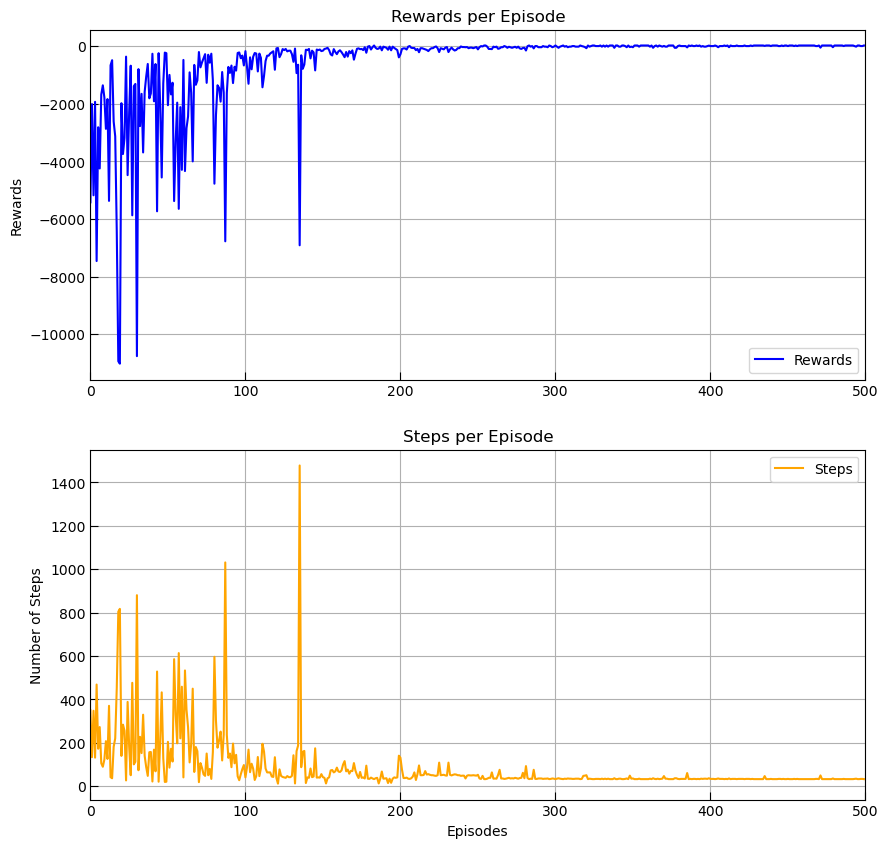

In [30]:
import matplotlib.pyplot as plt
set_seed(44)

def reinforcement_sarsa_visual(alpha, gamma, epsilon_start=1.0, epsilon_decay=0.01, min_epsilon=0.01):
    # Constants
    size = 20 # size of the canvas/coordination system
    start_position = (19, 12) # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]] 
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Initialize number of states and actions
    number_of_actions = 5  # left, right, up, down, park
    number_of_states = field.get_number_of_states()


 
    # Create empty Q-table with small random values
    # q_table = np.random.rand(number_of_states, number_of_actions) * 0.1
    q_table = np.random.rand(number_of_states, number_of_actions)

    # Hyperparameters
    epsilon = epsilon_start  # initial exploration probability
    max_epsilon = epsilon_start

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    # # Create the frame folder if it doesn't exist
    frame_folder = "frame_sarsa"
    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)

    for episode in range(train_episodes):
        # Reinitialize environment for each episode
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        field.reset()
        done = False
        step = 0
        total_training_rewards = 0

        # Initial state and action
        state = field.get_state()
        if random.uniform(0, 1) > epsilon:  # Exploit
            action = np.argmax(q_table[state])
        else:  # Explore
            action = random.randint(0, 4)

        while not done:
            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Select next action (SARSA-specific step)
            if random.uniform(0, 1) > epsilon:  # Exploit
                new_action = np.argmax(q_table[new_state])
            else:  # Explore
                new_action = random.randint(0, 4)

            # Update Q-value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * q_table[new_state, new_action] - q_table[state, action]
            )

            # Update state and action
            state = new_state
            action = new_action
            step += 1

            # # Save the current state as an image for the last episode
            if episode == train_episodes - 1:
                image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)
                print(f"---------STEP-{step}---------")

                # Save the image as PNG in the "frame" folder
                image.save(f"{frame_folder}/episode_{episode}_step_{step}.png")

        # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), np.mean(training_rewards), steps, training_rewards, epsilons, target_or_not, q_table

avg_steps, avg_rewards, steps, training_rewards, epsilons, target_or_not, q_table = reinforcement_sarsa_visual(alpha=0.1, gamma=0.1, epsilon_start=1.0, epsilon_decay=0.01, min_epsilon=0.01)
visualize_training_results(steps, training_rewards)


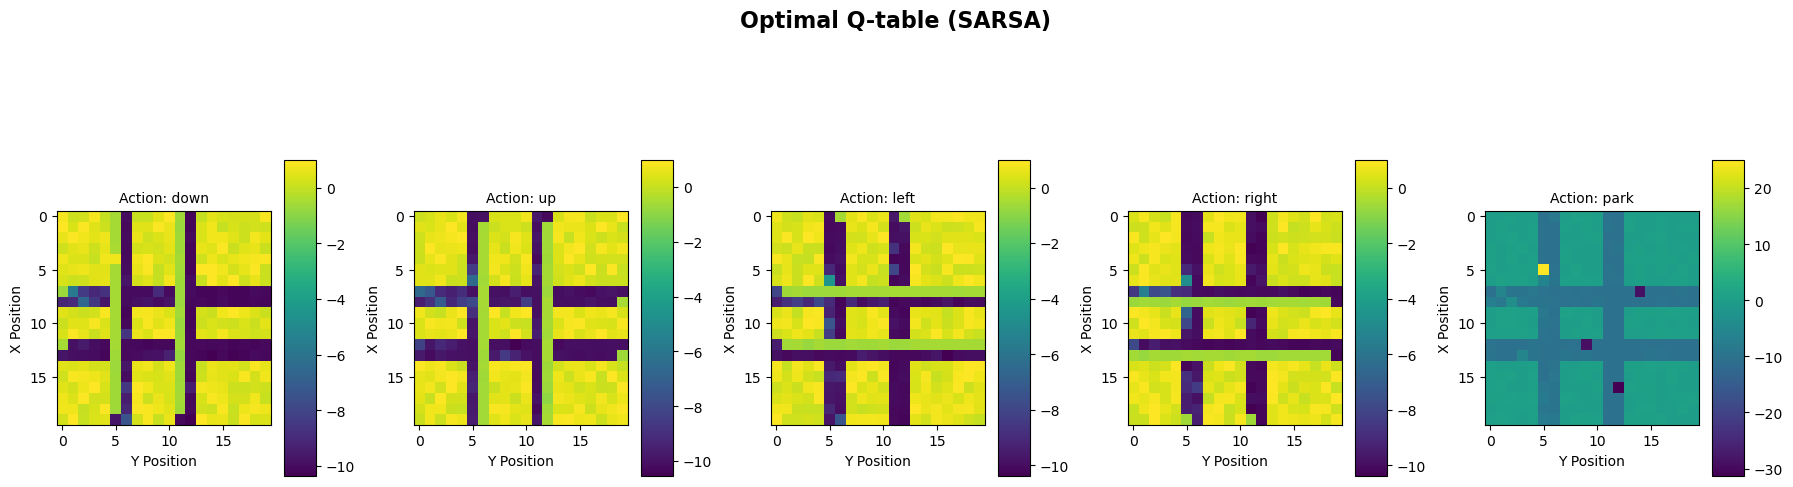

In [33]:
def visualize_q_table_parking_with_labels_reflected(q_table, grid_size=20):
    """
    Visualize Q-table for parking environment as heatmaps for each action, reflected across y = x axis.

    Parameters:
    - q_table: ndarray, shape (num_states, num_actions), Q-values for all states and actions.
    - grid_size: Integer, the size of the grid (e.g., 20 for a 20x20 grid).
    """
    # Convert Q-table to NumPy array if needed
    q_table = np.array(q_table)

    # Number of actions
    num_actions = q_table.shape[1]
    action_labels = ["down", "up", "left", "right", "park"]

    # Separate Q-values for parked (T) and not parked (F) states
    q_table_not_parked = q_table[::2, :]  # States where parking is False

    # Reflect the data across y = x by transposing
    def reflect_across_y_equals_x(data, action, grid_size):
        reshaped = data[:, action].reshape(grid_size, grid_size)
        return reshaped.T  # Transpose the grid to reflect across y = x

    plt.figure(figsize=(18, 10))
    plt.suptitle("Optimal Q-table (SARSA)", fontsize=16, weight='bold')  # Add the title

    for action in range(num_actions):
        # Plot Q-values for not parked states
        plt.subplot(2, num_actions, action + 1)
        reflected_not_parked = reflect_across_y_equals_x(q_table_not_parked, action, grid_size)
        im = plt.imshow(
            reflected_not_parked,
            cmap="viridis",
            interpolation="nearest"
        )
        plt.title(f"Action: {action_labels[action]}", fontsize=10)
        plt.xlabel("Y Position")
        plt.ylabel("X Position")

        # Adjust the colorbar size and position
        cbar = plt.colorbar(im, shrink=0.7, aspect=10)  # Reduce the colorbar size

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

# 시각화 실행
visualize_q_table_parking_with_labels_reflected(q_table, grid_size=20)


# Expected SARSA

In [35]:
set_seed(44)

def reinforcement_expected_sarsa(alpha, gamma):
    # Constants
    size = 20  # size of the canvas/coordination system
    start_position = (19, 12)  # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]]  # all empty parking space location

    # Initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Create number of states and actions
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # Create empty Q-table
    q_table = np.random.rand(number_of_states, number_of_actions)*0.1
    
    # # Create the frame folder if it doesn't exist
    # frame_folder = "frame_expected_sarsa_base"
    # if not os.path.exists(frame_folder):
    #     os.makedirs(frame_folder)

    # Hyperparameters
    epsilon = 1.0  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay = 0.01

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    for episode in range(train_episodes):
        # Initialize environment
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False
        step = 0
        total_training_rewards = 0
        state = field.get_state()

        while not done:
            # Choose action using epsilon-greedy policy
            if random.uniform(0, 1) > epsilon:  # Exploit
                action = np.argmax(q_table[state])
            else:  # Explore
                action = random.randint(0, number_of_actions - 1)

            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Calculate the expected Q value for the next state
            policy = np.ones(number_of_actions) * epsilon / number_of_actions  # Initialize uniform policy
            best_action = np.argmax(q_table[new_state])
            policy[best_action] += (1.0 - epsilon)  # Epsilon-greedy adjustment

            expected_q = np.sum(policy * q_table[new_state])  # Calculate expected Q value

            # Update Q value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * expected_q - q_table[state, action]
            )
            state = new_state
            step += 1
        #     if episode == train_episodes-1:
        #         print(f"---------STEP-{step}---------")

        #         image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

        #         # Save the image as PNG in the "frame" folder
        #         image.save(f"frame_expected_sarsa_base/episode_{episode}_step_{step}.png")
        # # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons

In [36]:
# define the range of alpha and gamma values to explore
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9]

results_list = []  # dictionary to store the results

for alpha in alpha_values:
    for gamma in gamma_values:

        avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_sarsa(alpha, gamma)

        count = 0
        for el in target_or_not:
            if el:
                count += 1

        results = {"alpha": alpha, "gamma": gamma, "avg_steps": avg_steps, "avg_rewards": avg_rewards,
                   "hitting_target": int(count / len(target_or_not) * 100)}
        results_list.append(results)

# print the results
for el in results_list:
    alpha = el["alpha"]
    gamma = el["gamma"]
    avg_step = el["avg_steps"]
    avg_rewards = el["avg_rewards"]
    hitting_target = el["hitting_target"]
    print(
        f"Alpha: {alpha}, Gamma: {gamma}, Avg Steps: {avg_step}, Avg Rewards: {avg_rewards}, Hitting Target: {hitting_target}%")

Alpha: 0.1, Gamma: 0.1, Avg Steps: 81.694, Avg Rewards: -544.3470255707963, Hitting Target: 85%
Alpha: 0.1, Gamma: 0.3, Avg Steps: 102.19, Avg Rewards: -589.3180560726976, Hitting Target: 88%
Alpha: 0.1, Gamma: 0.5, Avg Steps: 182.602, Avg Rewards: -946.2266425188844, Hitting Target: 79%
Alpha: 0.1, Gamma: 0.7, Avg Steps: 233.058, Avg Rewards: -943.3975002917305, Hitting Target: 81%
Alpha: 0.1, Gamma: 0.9, Avg Steps: 204.53, Avg Rewards: -958.2619857089039, Hitting Target: 80%
Alpha: 0.3, Gamma: 0.1, Avg Steps: 147.328, Avg Rewards: -763.8620341035883, Hitting Target: 80%
Alpha: 0.3, Gamma: 0.3, Avg Steps: 129.468, Avg Rewards: -634.641389993289, Hitting Target: 86%
Alpha: 0.3, Gamma: 0.5, Avg Steps: 198.452, Avg Rewards: -801.9233097809947, Hitting Target: 84%
Alpha: 0.3, Gamma: 0.7, Avg Steps: 190.656, Avg Rewards: -885.6545592853414, Hitting Target: 83%
Alpha: 0.3, Gamma: 0.9, Avg Steps: 296.14, Avg Rewards: -1101.4549288995702, Hitting Target: 83%
Alpha: 0.5, Gamma: 0.1, Avg Steps:

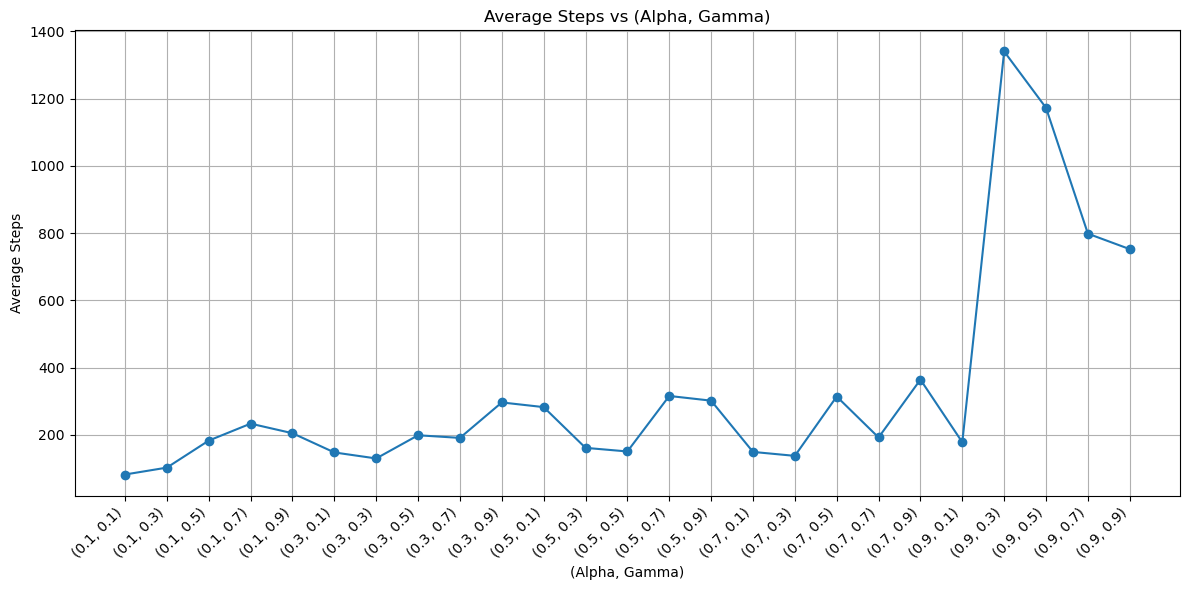

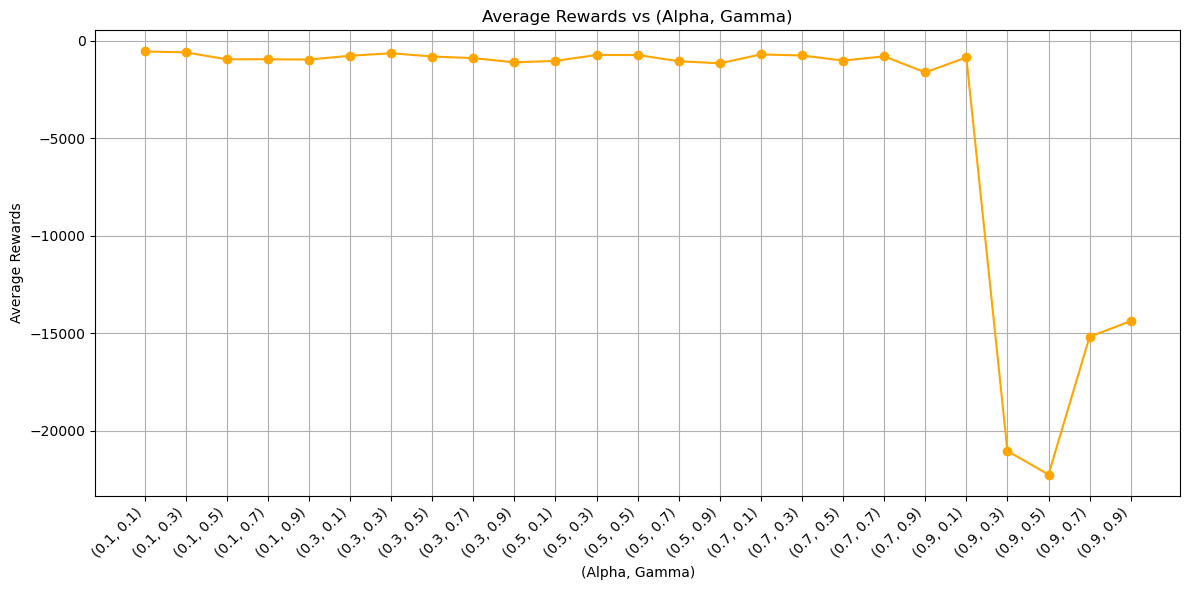

Best Average Steps: 81.694 at parameters (0.1, 0.1)
Best Average Rewards: -544.3470255707963 at parameters (0.1, 0.1)


In [37]:
def plot_results(results_list):
    # Prepare data for plotting
    labels = []  # To store (alpha, gamma) labels
    avg_steps = []
    avg_rewards = []

    for res in results_list:
        labels.append(f"({res['alpha']}, {res['gamma']})")
        avg_steps.append(res["avg_steps"])
        avg_rewards.append(res["avg_rewards"])

    # Plot avg_steps
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_steps, marker='o', label="Average Steps")
    plt.title("Average Steps vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Steps")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot avg_rewards
    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_rewards, marker='o', label="Average Rewards", color='orange')
    plt.title("Average Rewards vs (Alpha, Gamma)")
    plt.xlabel("(Alpha, Gamma)")
    plt.ylabel("Average Rewards")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Find best parameters
    best_avg_steps = min(zip(avg_steps, labels))
    best_avg_rewards = max(zip(avg_rewards, labels))

    print(f"Best Average Steps: {best_avg_steps[0]} at parameters {best_avg_steps[1]}")
    print(f"Best Average Rewards: {best_avg_rewards[0]} at parameters {best_avg_rewards[1]}")
# Example usage:
plot_results(results_list)

In [43]:
set_seed(44)

def reinforcement_expected_sarsa_visual(alpha, gamma):
    # Constants
    size = 20  # size of the canvas/coordination system
    start_position = (19, 12)  # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]]  # all empty parking space location

    # Initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Create number of states and actions
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # Create empty Q-table
    q_table = np.random.rand(number_of_states, number_of_actions)
    
    # Create the frame folder if it doesn't exist
    frame_folder = "frame_expected_sarsa"
    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)

    # Hyperparameters
    epsilon = 1.0  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay = 0.01

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    for episode in range(train_episodes):
        # Initialize environment
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False
        step = 0
        total_training_rewards = 0
        state = field.get_state()

        while not done:
            # Choose action using epsilon-greedy policy
            if random.uniform(0, 1) > epsilon:  # Exploit
                action = np.argmax(q_table[state])
            else:  # Explore
                action = random.randint(0, number_of_actions - 1)

            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Calculate the expected Q value for the next state
            policy = np.ones(number_of_actions) * epsilon / number_of_actions  # Initialize uniform policy
            best_action = np.argmax(q_table[new_state])
            policy[best_action] += (1.0 - epsilon)  # Epsilon-greedy adjustment

            expected_q = np.sum(policy * q_table[new_state])  # Calculate expected Q value

            # Update Q value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * expected_q - q_table[state, action]
            )
            state = new_state
            step += 1
            if episode == train_episodes-1:
                print(f"---------STEP-{step+1}---------")

                image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

                # Save the image as PNG in the "frame" folder
                image.save(f"frame_expected_sarsa/episode_{episode}_step_{step}.png")
        # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons

---------STEP-2---------
---------STEP-3---------
---------STEP-4---------
---------STEP-5---------
---------STEP-6---------
---------STEP-7---------
---------STEP-8---------
---------STEP-9---------
---------STEP-10---------
---------STEP-11---------
---------STEP-12---------
---------STEP-13---------
---------STEP-14---------
---------STEP-15---------
---------STEP-16---------
---------STEP-17---------
---------STEP-18---------
---------STEP-19---------
---------STEP-20---------
---------STEP-21---------
---------STEP-22---------
---------STEP-23---------
---------STEP-24---------
---------STEP-25---------
---------STEP-26---------
---------STEP-27---------
---------STEP-28---------
---------STEP-29---------
---------STEP-30---------
---------STEP-31---------
---------STEP-32---------
---------STEP-33---------
---------STEP-34---------
---------STEP-35---------
---------STEP-36---------
---------STEP-37---------
---------STEP-38---------
---------STEP-39---------
---------STEP-40----

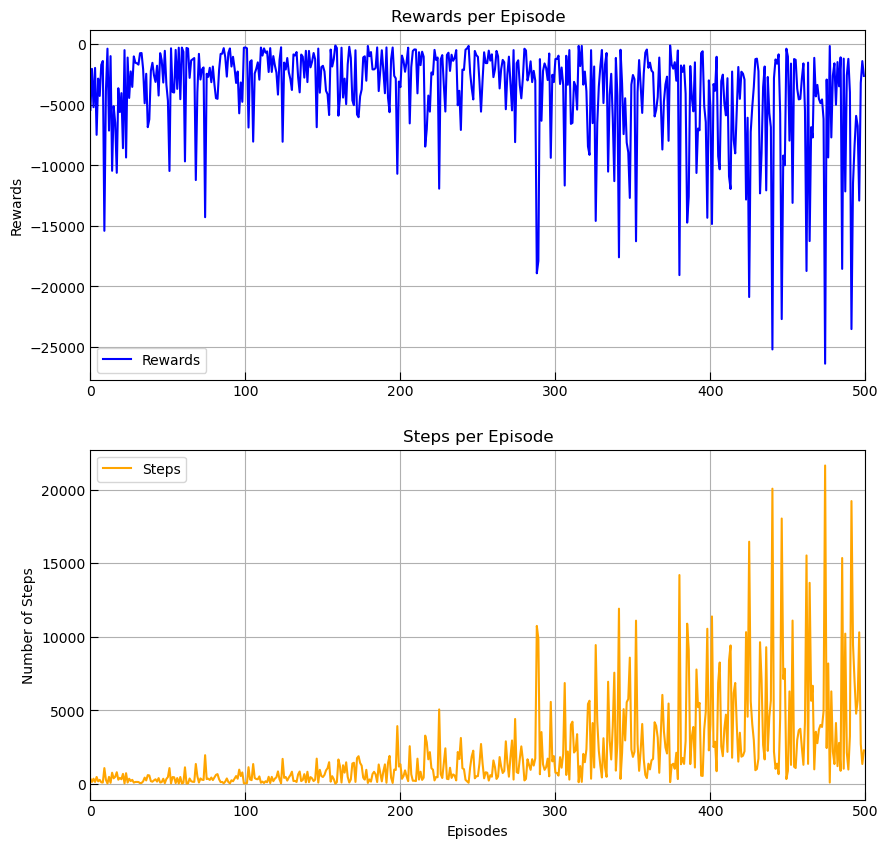

In [44]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_visual(alpha = 0.1, gamma = 0.1)
visualize_training_results(steps, training_rewards)

In [61]:
set_seed(44)

def reinforcement_expected_sarsa_test(alpha, gamma, max_epsilon=1.0, decay=0.01, min_epsilon=0.01):
    # Constants
    set_seed(44)
    
    size = 20  # size of the canvas/coordination system
    start_position = (19, 12)  # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]]  # all empty parking space location

    # Initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Create number of states and actions
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    
    # Create empty Q-table
    q_table = np.random.rand(number_of_states, number_of_actions)
    
    # # Create the frame folder if it doesn't exist
    # frame_folder = "frame_expected_sarsa"
    # if not os.path.exists(frame_folder):
    #     os.makedirs(frame_folder)

    # Hyperparameters
    epsilon = 1.0  # initial exploration probability
    max_epsilon = max_epsilon
    min_epsilon = min_epsilon
    decay = decay

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    for episode in range(train_episodes):
        # Initialize environment
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False
        step = 0
        total_training_rewards = 0
        state = field.get_state()

        while not done:
            
            # Choose action using epsilon-greedy policy
            if random.uniform(0, 1) > epsilon:  # Exploit
                action = np.argmax(q_table[state])
            else:  # Explore
                action = random.randint(0, number_of_actions - 1)

            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Calculate the expected Q value for the next state
            policy = np.ones(number_of_actions) * epsilon / number_of_actions  # Initialize uniform policy
            best_action = np.argmax(q_table[new_state])
            policy[best_action] += (1.0 - epsilon)  # Epsilon-greedy adjustment

            expected_q = np.sum(policy * q_table[new_state])  # Calculate expected Q value

            # Update Q value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * expected_q - q_table[state, action]
            )
            state = new_state
            step += 1
            # if episode == train_episodes-1:
            #     print(f"---------STEP-{step+1}---------")

            #     image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

            #     # Save the image as PNG in the "frame" folder
            #     image.save(f"frame_expected_sarsa/episode_{episode}_step_{step}.png")
        # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons

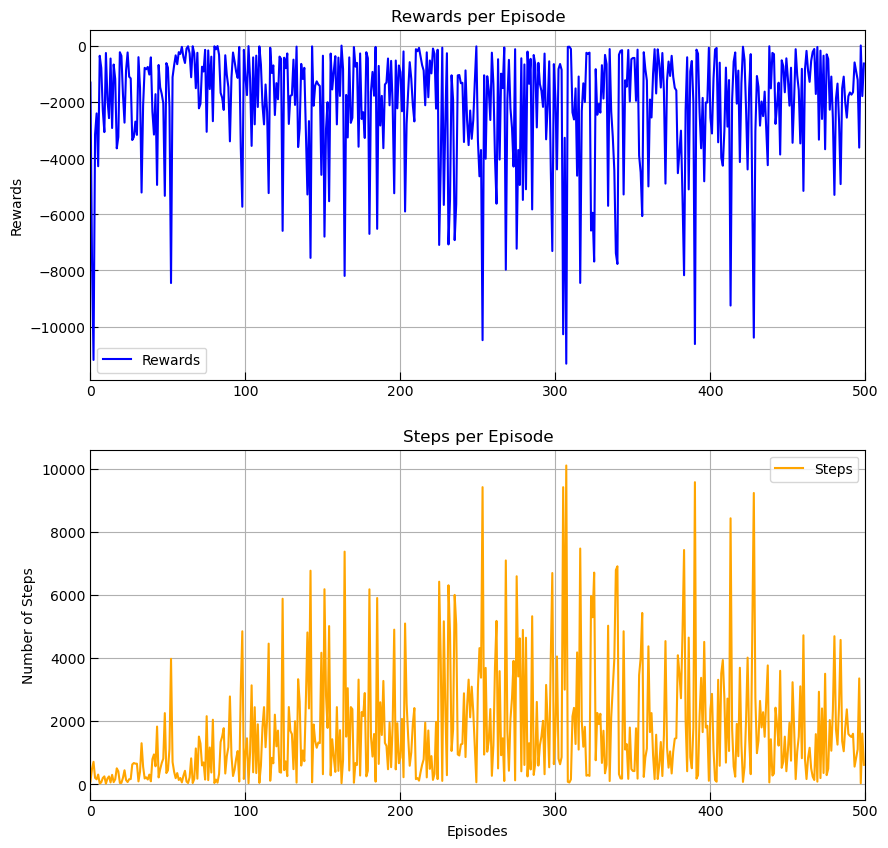

In [52]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_test(alpha=0.1, gamma=0.1, max_epsilon=1.0, decay=0.05, min_epsilon=0.01)
visualize_training_results(steps, training_rewards)

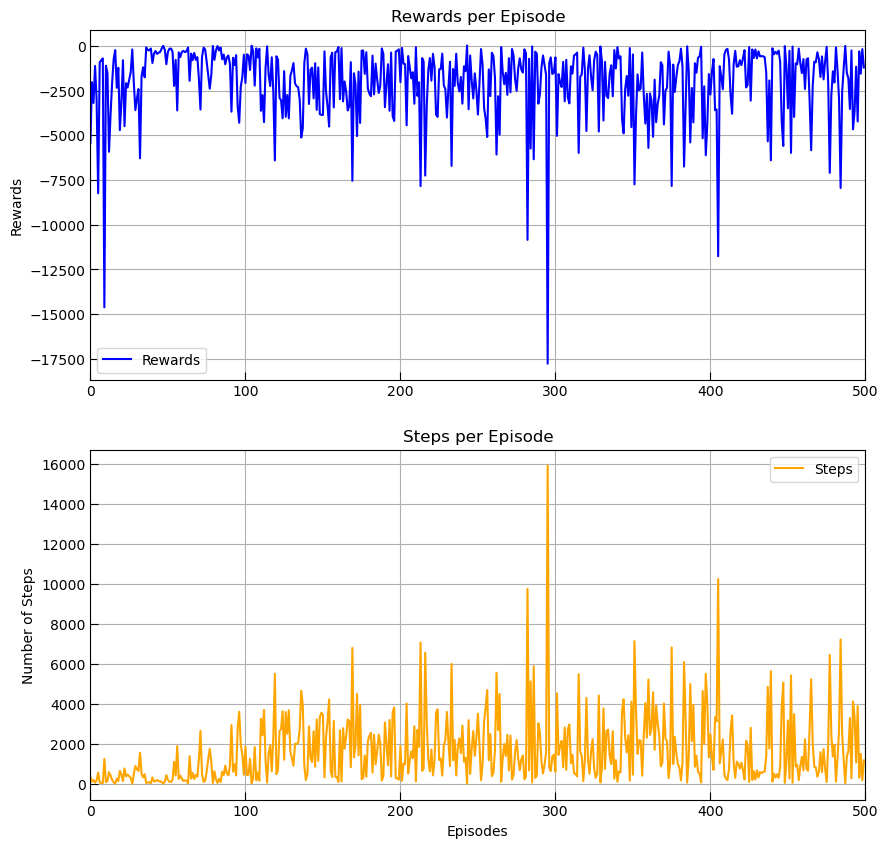

In [62]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_test(alpha=0.1, gamma=0.1, max_epsilon=1.0, decay=0.05, min_epsilon=0.01)
visualize_training_results(steps, training_rewards)

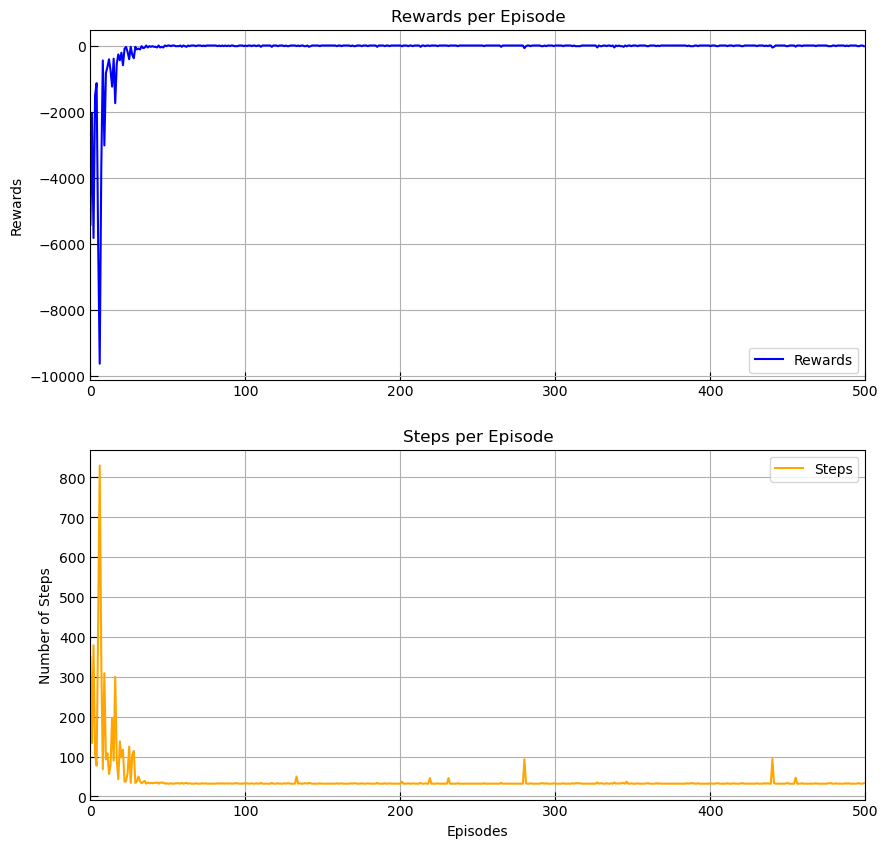

In [63]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_test(alpha=0.1, gamma=0.1, max_epsilon=1.0, decay=0.075, min_epsilon=0.01)
visualize_training_results(steps, training_rewards)

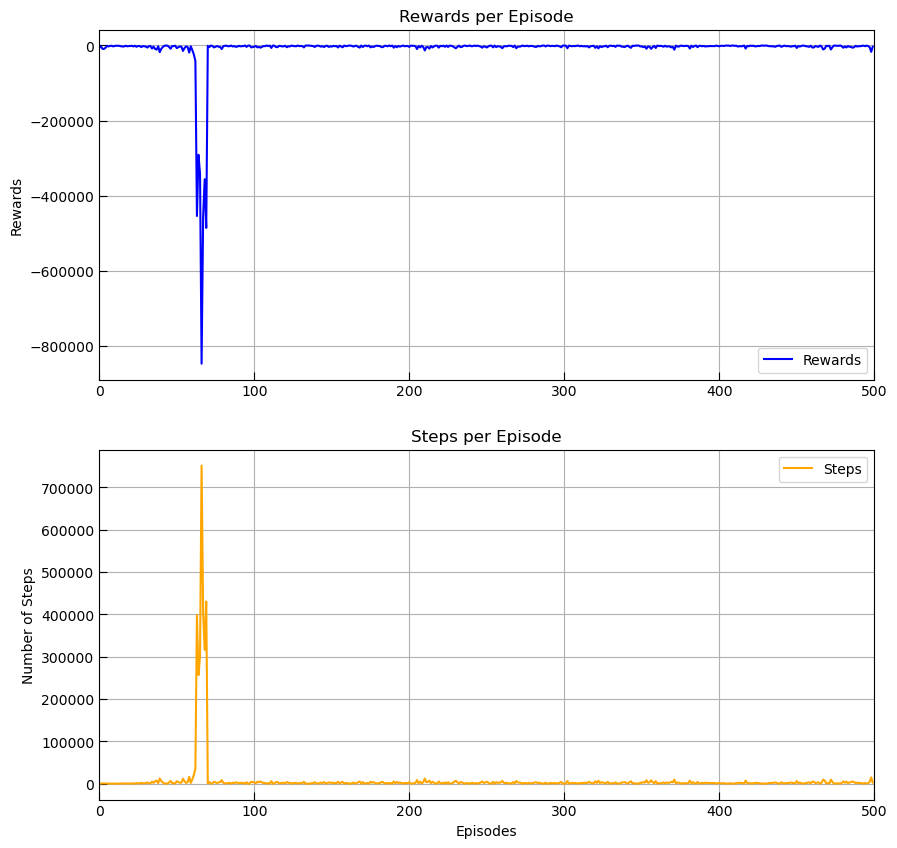

In [64]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_test(alpha=0.1, gamma=0.1, max_epsilon=1.0, decay=0.1, min_epsilon=0.01)
visualize_training_results(steps, training_rewards)

In [65]:
set_seed(44)

def reinforcement_expected_sarsa_final(alpha, gamma):
    # Constants
    size = 20  # size of the canvas/coordination system
    start_position = (19, 12)  # start agent from this position
    target_position = (5, 5)  # give target location to park
    parking_lot_coor = [[12, 16], [9, 12], [14, 7], [5, 5]]  # all empty parking space location

    # Initialize environment
    field = Field_4(size, start_position, target_position, parking_lot_coor)
    field.reset()
    # Create number of states and actions
    number_of_states = field.get_number_of_states()
    number_of_actions = 5  # left, right, up, down, park

    # Create empty Q-table
    q_table = np.random.rand(number_of_states, number_of_actions)
    
    # Create the frame folder if it doesn't exist
    frame_folder = "frame_expected_sarsa_final"
    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)

    # Hyperparameters
    epsilon = 1.0  # initial exploration probability
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay = 0.075

    # Episodes
    train_episodes = 500

    # Metrics
    steps = []
    target_or_not = []
    end_locations = []
    training_rewards = []
    epsilons = []

    for episode in range(train_episodes):
        # Initialize environment
        field = Field_4(size, start_position, target_position, parking_lot_coor)
        done = False
        step = 0
        total_training_rewards = 0
        state = field.get_state()

        while not done:
            # Choose action using epsilon-greedy policy
            if random.uniform(0, 1) > epsilon:  # Exploit
                action = np.argmax(q_table[state])
            else:  # Explore
                action = random.randint(0, number_of_actions - 1)

            # Take action and observe reward and next state
            reward, done = field.make_action(action)
            total_training_rewards += reward
            new_state = field.get_state()

            # Calculate the expected Q value for the next state
            policy = np.ones(number_of_actions) * epsilon / number_of_actions  # Initialize uniform policy
            best_action = np.argmax(q_table[new_state])
            policy[best_action] += (1.0 - epsilon)  # Epsilon-greedy adjustment

            expected_q = np.sum(policy * q_table[new_state])  # Calculate expected Q value

            # Update Q value
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (
                reward + gamma * expected_q - q_table[state, action]
            )
            state = new_state
            step += 1
            if episode == train_episodes-1:
                print(f"---------STEP-{step}---------")

                image = draw_area(start_position, target_position, parking_lot_coor, field.position, episode, step)

                # Save the image as PNG in the "frame" folder
                image.save(f"frame_expected_sarsa_final/episode_{episode}_step_{step}.png")
        # Check if the agent reached the target
        target_tf = field.position == field.target_position

        # Exploration decay
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

        # Append metrics
        epsilons.append(epsilon)
        steps.append(step)
        target_or_not.append(target_tf)
        end_locations.append(field.position)
        training_rewards.append(total_training_rewards)

    return np.mean(steps), training_rewards, np.mean(training_rewards), steps, target_or_not, epsilons

---------STEP-1---------
---------STEP-2---------
---------STEP-3---------
---------STEP-4---------
---------STEP-5---------
---------STEP-6---------
---------STEP-7---------
---------STEP-8---------
---------STEP-9---------
---------STEP-10---------
---------STEP-11---------
---------STEP-12---------
---------STEP-13---------
---------STEP-14---------
---------STEP-15---------
---------STEP-16---------
---------STEP-17---------
---------STEP-18---------
---------STEP-19---------
---------STEP-20---------
---------STEP-21---------
---------STEP-22---------
---------STEP-23---------
---------STEP-24---------
---------STEP-25---------
---------STEP-26---------
---------STEP-27---------
---------STEP-28---------
---------STEP-29---------
---------STEP-30---------
---------STEP-31---------
---------STEP-32---------
---------STEP-33---------


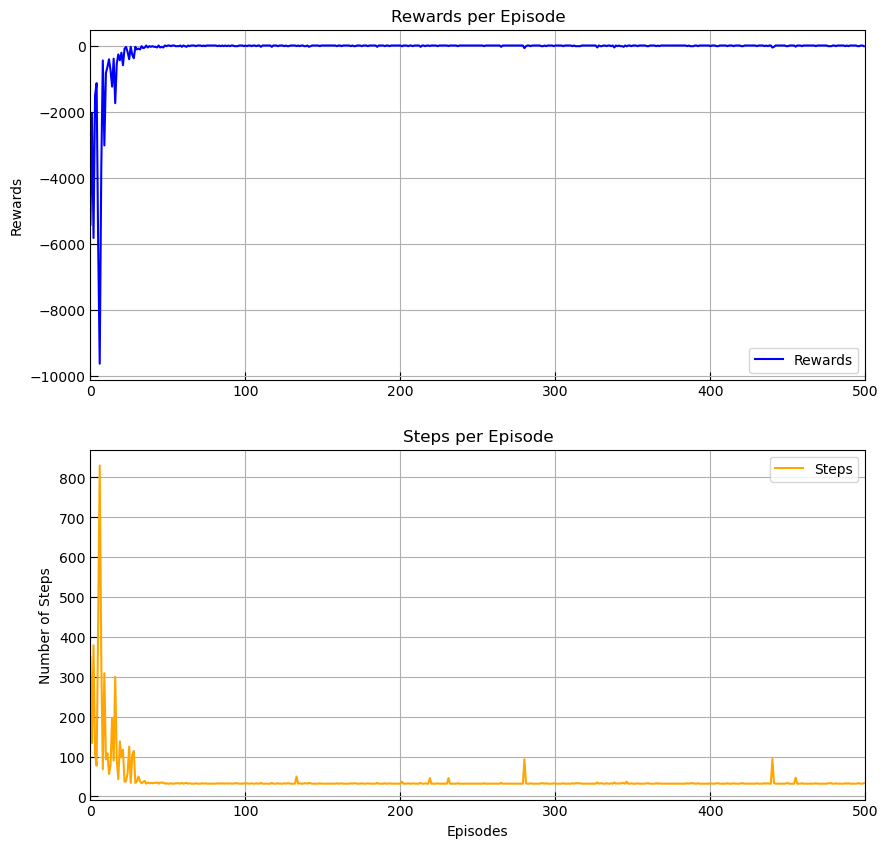

In [66]:
avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_final(alpha=0.1, gamma=0.1)
visualize_training_results(steps, training_rewards)

In [53]:
# Define the range of alpha, gamma, and epsilon hyperparameters to explore
epsilon_decay_values = [0.01, 0.05, 0.1, 0.5, 0.95]
epsilon_min_values = [0.01, 0.001, 0.0001]

results_list = []  # List to store the results
for epsilon_decay in epsilon_decay_values:
    for min_epsilon in epsilon_min_values:
            avg_steps, training_rewards, avg_rewards, steps, target_or_not, epsilons = reinforcement_expected_sarsa_test(
                 alpha=0.1, gamma=0.1, max_epsilon=1.0, decay=epsilon_decay, min_epsilon=min_epsilon)

            count = 0
            for el in target_or_not:
                if el:
                    count += 1

            results = {
                "epsilon_decay": epsilon_decay,
                "min_epsilon":min_epsilon,
                "avg_steps": avg_steps,
                "avg_rewards": avg_rewards,
                "hitting_target": int(count / len(target_or_not) * 100)
            }
            results_list.append(results)

# Print the results
for el in results_list:
    epsilon_decay = el["epsilon_decay"]
    min_epsilon = el["min_epsilon"]
    avg_step = el["avg_steps"]
    avg_rewards = el["avg_rewards"]
    hitting_target = el["hitting_target"]
    print(f"Epsilon Decay: {epsilon_decay}, Min_Epsilon: {min_epsilon}, Avg Steps: {avg_step}, Avg Rewards: {avg_rewards}, Hitting Target: {hitting_target}%")


KeyboardInterrupt: 

## Class

In [84]:
class Field_4_cost5:
    def __init__(self, size, start_position, target_position, parking_lot_coor):
        self.size = size
        self.parking = False  # true or false, park or not park, start with not park
        self.target_position = target_position  # there is a target position which has high reward
        self.position = start_position  # determine start position
        self.parking_lot_coor = parking_lot_coor  # there are other empty lots, keep them in a list
        self.start_position = start_position

    def reset(self):
        """Reset the environment to the initial state."""
        self.position = self.start_position  # Reset agent's position to the start
        # Add other resetting logic if needed, e.g., rewards, obstacles, etc.
        return self.get_state()  # Return the initial state

    def get_number_of_states(self):
        return self.size * self.size * 2  # multiply by 2 to add status of parked or not

    def get_state(self):
        # print(self.position)
        # state goes like (0,0,F), (0,0,T), (0,1,F), (0,1,T), (0,2,F)...
        state = self.position[0] * self.size * 2
        state = state + self.position[1] * 2

        # if parking is done, you'll be in the next state F-->T (*,*,T)
        if self.parking:
            state = state + 1
        return state

    def make_action(self, action):

        def calc_reward():
            distance = math.dist(self.position, self.target_position)

            # we want to maximize reward, minimize distance
            reward = -1 * (distance)

            return reward

        (x, y) = self.position
        if action == 0:  # down
            if y == self.size - 1: # penalize for out of canvas
                return -20, False
            elif x == 5 or x == 11: # go in the true direction
                self.position = (x, y + 1)
                return -5, False
            elif (x, y) == (0, 7) or (x, y) == (0, 12): # go in the true direction
                self.position = (x, y + 1)
                return -5, False
            else:
                return -20, False # penalize for out of road

        elif action == 1:  # up
            if y == 0: # penalize for out of canvas
                return -20, False
            elif x == 6 or x == 12: # go in the true direction
                self.position = (x, y - 1)
                return -5, False
            elif (x, y) == (self.size - 1, 8) or (x, y) == (self.size - 1, 13): # go in the true direction
                self.position = (x, y - 1)
                return -5, False
            else:
                return -20, False # penalize for out of road

        elif action == 2:  # left
            if x == 0: # penalize for out of canvas
                return -20, False
            elif y == 7 or y == 12: # go in the true direction
                self.position = (x - 1, y)
                return -5, False
            elif (x, y) == (6, 0) or (x, y) == (12, 0): # go in the true direction
                self.position = (x - 1, y)
                return -5, False
            else:
                return -20, False # penalize for out of road

        elif action == 3:  # right
            if x == self.size - 1: # penalize for out of canvas
                return -20, False
            elif y == 8 or y == 13: # go in the true direction
                self.position = (x + 1, y)
                return -5, False
            elif (x, y) == (5, self.size - 1) or (x, y) == (11, self.size - 1): # go in the true direction
                self.position = (x + 1, y)
                return -5, False
            else:
                return -20, False # penalize for out of road

        elif action == 4:  # park
            if [x, y] not in self.parking_lot_coor: # if it's not a parking lot
                return -20, False
            elif self.target_position == (x, y):
                reward = calc_reward()
                self.parking = True
                return reward + 50, True # yey it's target!!! #calculate -distance + 20 as a reward
            else:
                reward = calc_reward()
                self.parking = True
                return reward - 50, True # no target position but it's a lot #finish the loop #calculate -distance as a reward

